# MIGHTEE-HI Data Analysis v13
***

By Wanga Mulaudzi, based on work by Sambatra Rajohnson, Marcin Glowacki and Bradley Frank.

This notebook:
* Applies a primary beam correction to the data cube using python,
* Extracts spectra from cubelets in the data cube after having performed source finding to get their locations,
* Calculates the redshifts, Hubble Distances and HI masses from the HI profiles, 
* Calculates velocity widths from the HI profiles

In [93]:
# Import statements
import aplpy
from astropy.io import ascii
from astropy.io import fits
from astropy import cosmology
from astropy.cosmology import WMAP7
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
import heapq
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import math
from scipy.optimize import curve_fit
import scipy as sp
import sklearn
import seaborn as sns
import spectral_cube
from spectral_cube import SpectralCube
from spectral_cube.cube_utils import Beam
%matplotlib inline

In [2]:
# Initiate parameters for plotting
pl.rc('axes',titlesize='large')
pl.rc('text', usetex=False)
pl.rc('font', **{'family':'serif','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)

# 1. Reading in the data

In [3]:
# Read in the main cube
cube_file = '/idia/projects/mightee/mightee-hi/XMMLSS12/12/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.image.u.piwimed.fits'
cube = SpectralCube.read(cube_file)

# Store the header in a variable
hdulist = fits.open(cube_file)

# Get the table of beams
beam_table = hdulist[1].data

# Display information about the cube
cube

VaryingResolutionSpectralCube with shape=(186, 4096, 4096) and unit=Jy / beam:
 n_x:   4096  type_x: RA---SIN  unit_x: deg    range:    33.319000 deg:   35.606558 deg
 n_y:   4096  type_y: DEC--SIN  unit_y: deg    range:    -5.969952 deg:   -3.694804 deg
 n_s:    186  type_s: FREQ      unit_s: Hz     range: 1380142385.889 Hz:1418804763.446 Hz

From the information above, we can see the RA and Dec ranges, and that the total bandwidth of the cube is 50 MHz. 

We now have to read in primary beam, which is created by the ```tclean``` task in ```CASA```. This particular primary beam has no grid, i.e. the continuum was fit over the whole cube, with a polynomial of order N = 5.

In [4]:
# Read in the primary beam file
pb_file = '/idia/projects/mightee/mightee-hi/XMMLSS12/12/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.pb.u.e.fits'
pb = SpectralCube.read(pb_file)

pb

SpectralCube with shape=(186, 4096, 4096):
 n_x:   4096  type_x: RA---SIN  unit_x: deg    range:    33.319000 deg:   35.606558 deg
 n_y:   4096  type_y: DEC--SIN  unit_y: deg    range:    -5.969952 deg:   -3.694804 deg
 n_s:    186  type_s: FREQ      unit_s: Hz     range: 1380142385.889 Hz:1418804763.446 Hz

# 2. Primary beam correction
We can now perform the primary beam correction, which can also be done in ```CASA```:

## 2.1. If the primary beam correction has not yet been done:

In [6]:
# Extract the header and data of the cube
cubehead = fits.getheader(cube_file)
cubedata = fits.getdata(cube_file)

# Check the shape of the cube
shape = cubedata.shape

# Check how many dimenstions shape has
if len(shape) == 4:
        # Assign each value and the dimension
        # nc is the number of cubes
        # nf is the number of frequency/velocity channels
        # ny is the number of DEC points
        # nx is the number of RA points
        nc, nf, ny, nx = shape 
        dim = 4
elif len(shape) == 2:
        ny, nx = S
        dim = 2
else:
    raise(Exception, "I don't know how to handle a cube with this shape: "+str(shape))
    
# Extract the header and data of the primary beam
pbhead = fits.getheader(pb_file)
pbdata = fits.getdata(pb_file)

# Causes WCS init problem if zero
if pbhead['CDELT4'] == 0.0:
    pbhead['CDELT4'] = -8.236827542606E+07
    
# Primary beam correction by dividing the image by the pb
pbcordat = cubedata / pbdata

# Check the shape of the primary beam corrected cube
pbshape = pbcordat.shape

# Check how many dimenstions pbshape has
if len(pbshape) == 4:
        pbnc, pbnf, pbny, pbnx = pbshape
        pbdim = 4
elif len(pbshape) == 2:
        pbny, pbnx = pbS
        ndim = 2
else:
        raise(Exception, "I don't know how to handle a primary beam corrected cube with this shape: "+str(pbshape))

# Save the primary beam corrected file
outfile = '/idia/users/wanga/mightee/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.image.u.e.piwimed.pbcorr.fits'
fits.writeto(outfile, pbcordat, header = hdulist[0].header)
fits.append(outfile, beam_table, header = hdulist[1].header)

## 2.2. If the primary beam correction has already been done:

We can now read in the primary beam corrected cube, which was done in ```Python```:

In [7]:
# Read in the primary beam corrected cube
pbcordat_file = '/idia/users/wanga/mightee/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.image.u.e.piwimed.pbcorr.fits'
pbcordat = SpectralCube.read(pbcordat_file)

pbcordat

VaryingResolutionSpectralCube with shape=(186, 4096, 4096) and unit=Jy / beam:
 n_x:   4096  type_x: RA---SIN  unit_x: deg    range:    33.319000 deg:   35.606558 deg
 n_y:   4096  type_y: DEC--SIN  unit_y: deg    range:    -5.969952 deg:   -3.694804 deg
 n_s:    186  type_s: FREQ      unit_s: Hz     range: 1380142385.889 Hz:1418804763.446 Hz

# 3. Extracting subcubes

Now that we have a primary beam corrected image, we can extract subcubes around each detection using their positions and frequencies at which the detections occur and plot the HI spectra.

We can list the detections with their RA, Dec, center frequency, optical RA, optical Dec and additional notes.

In [9]:
detections = ascii.read('/users/wanga/mightee/source_finding/XMMLSS12_1_2.1380.UVCON1_notes_Wanga.dat', header_start = 0, data_start = 1)
detections

Region,RA,Dec,OptRA,OptDec,Reference,Freq,Notes
int64,float64,float64,float64,float64,str14,float64,str7
1,34.2591,-5.0641,34.2591,-5.0641,-,1.38433,Normal
2,34.3107,-5.4907,34.3104,-5.4893,-,1.39613,Region3
3,34.328,-5.4751,34.3306,-5.4807,HIPASSJ0217-05,1.395585,Region2
4,34.655,-4.545,34.6511,-4.5434,-,1.40197,Normal
5,35.3695,-4.4171,35.3689,-4.4141,HIPASSJ0221-04,1.4095,Feint


In the next cell, a function called `get_spectrum` has been defined. It extracts a subcube from an input cube, and calculates the associated _mean_ and _median_ spectra from that sub-cube.

Note the following: 
* The `dfreq` variable should be input in the spectral units of the cube. In this notebook, this is GHz. This will be the frequency range at which we want the subcube to be extracted from given the central/observed frequency `freq`
* The output spectra are unit-less, which makes it easier to plot/analyses. The cube unit (e.g., Jy/beam) can be accessed by looking at the `cube.unit` keyword.
* This function outputs:
    * `target_subcube`: the subcube with the spectral axis in terms of frequency.
    * `freqs`: the frequency spectral axis of the subcube.
    * `target_spectrum_sum`: the sum flux density of each image slice.
    * `target_spectrum_median`: the median flux density of each image slice. 
    * `target_spectrum_mean`: the mean flux density of each image slice.
    * `vel`: the velocity spectral axis of the subcube.
    * `vel_subcube`: the subcube with the spectral axis in terms of velocity.

In [10]:
def get_spectrum(cube, ra, dec, freq, rad='30arcsec', dfreq=0.0005):
    '''
    cube is the input data cube
    ra of the center of the detection
    dec of the center of the detection
    freq of the center of the detection in GHz
    radius of 30 arcsec to be extracted
    dfreq is the frequency width of  500KHz
    '''
    freq_lower = '%.5fGHz' % (freq-dfreq) #frequency ranges
    freq_upper = '%.5fGHz' % (freq+dfreq)
    crtf_str = 'circle[['+ra+','+dec+'], '+rad+'], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    # fk5 is just another frame like icrs
    target_subcube = cube.subcube_from_crtfregion(crtf_str) # Extracting the new cube from the crtf region
    freqs = target_subcube.spectral_axis # The frequency units are in Hertz
    
    # Converting the cube spectral axis into km/s
    vel_subcube = target_subcube.with_spectral_unit(u.km / u.s, velocity_convention='relativistic', rest_value=1.42040575e9 * u.Hz) 
    # Storing the velocity axis value separately from the cube so that we can use later
    vel = vel_subcube.spectral_axis
    
    target_spectrum_sum = target_subcube.sum(axis=(1,2))
    target_spectrum_median = target_subcube.median(axis=(1,2))
    target_spectrum_mean = target_subcube.mean(axis=(1,2))

    return target_subcube, freqs, target_spectrum_sum, target_spectrum_median, target_spectrum_mean, vel, vel_subcube

## 3.1. An aside on radio and optical velocities

Notice how there is a velocity convention that is specified in `get_spectrum`. The conventions arise from the relativistic velocity equation

\begin{equation}
V = \frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}c, \\
\end{equation}

which is what we will use (see https://science.nrao.edu/facilities/vla/docs/manuals/obsguide/modes/line). But astronomers have made two approximations of this equation, one for optical velocities and the other for radio velocities. The general practice for optical measurements is to use wavelengths, so we need to change $V$ to be a function of wavelength using the fact that $\nu = \frac{c}{\lambda}$:

\begin{align}
V &= \frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}c \\
  &= \frac{\frac{c}{\lambda_0}^2 - \frac{c}{\lambda}^2}{\frac{c}{\lambda_0}^2 + \frac{c}{\lambda}^2}c \\
  &= \frac{c^2\frac{1}{\lambda_0^2} - \frac{1}{\lambda}}{c^2\frac{1}{\lambda_0^2} + \frac{1}{\lambda}}c \\
  &= c\frac{\lambda^2 - \lambda_0^2}{\lambda_0\lambda^2} \div \frac{\lambda^2 + \lambda_0^2}{\lambda_0\lambda^2} \\
  &= \frac{\lambda^2 - \lambda_0^2}{\lambda^2 + \lambda_0^2}c.
\end{align}

Now that we know the velocity equation in terms of wavelength, we can derive the optical velocity equation using the approximation that $z < 1$, where $z = \frac{\lambda-\lambda_0}{\lambda_0}$, implying that $\lambda_0 > \lambda$:

\begin{align}
V &= \frac{\lambda^2 - \lambda_0^2}{\lambda^2 + \lambda_0^2}c \\
  &= \frac{(\lambda - \lambda_0)(\lambda + \lambda_0)c}{\lambda^2 + \lambda_0^2} \\
  &= \frac{c(\lambda - \lambda_0)\lambda_0}{\lambda_0^2} \\
  &= \frac{c\lambda-\lambda_0}{\lambda_0} \\
\therefore V_{opt}  &= cz.
\end{align}

$V_{opt}$ is commonly used for heli/barycentric extragalactic observations, and/or if the observer wants to crossmatch the results with redshifts and so forth from optical data. 

We can repeat the same procedure for radio noting that the redshift formula in terms of frequency is now $z = \frac{\nu_0-\nu}{\nu}$. When measuring radio sources, the emitted frequency $\nu_0$ is always greater than the observed frequency $nu_0$ since the galaxies are moving away from us (redshifted). Recall that if you were to measure a $\nu$ that is higher than $\nu_0$, that would imply that the galaxy is moving towards us (blue-shifted), which cannot be true for the theory of an expanding universe. This condition, $\nu_0 > \nu$, is the approximation that derives the radio velocity formula:

\begin{align}
V &= \frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}c \\
  &= \frac{c(\nu_0 - \nu)(\nu_0 + \nu)}{\nu_0^2 + \nu^2} \\
  &= \frac{c(\nu_0 - \nu)\nu_0}{\nu_0^2} \\
  &= \frac{c(\nu_0 - \nu)}{\nu_0} \\
  &\neq V_{opt}.
\end{align}

$V_{rad}$ is commonly used for galactic observations, and if the observer is strictly working with radio surveys. $V_{opt}$ and $V_{rad}$ are only valid for small $z$, and therefore diverge for large velocities. 

## 3.2. Back to the subcube extractions

Subcubes of 2 arcmin radii are typically extracted, but sometimes you have feint sources or sources that are very close to each other that need smaller radii. Note that since doing the primary beam correction in Python results in cubes with lost beam information, the fluxes in the subcubes are still in Jy/beam even though the unit printed out is in Jy (e.g. print out Sum[0]. It will have its units in Jy and not Jy/beam).

In [11]:
# Initialise lists to store information
subcube = []      # subcube with frequency axis
freqs = []        # frequency in Hz
center_freqs = [] # center frequencies from .dat table
Sum = []          # sum value of the flux density in Jy/beam
med = []          # median value of the flux density in Jy/beam
mean = []         # mean value of the flux density in Jy/beam
vel = []          # velocity
vel_subcube = []  # subcube with velocity axis

# Extract the subcubes
for i in range(len(detections)):
    ra = str(detections[i]['RA'])     # taking the RA column
    dec = str(detections[i]['Dec'])   # taking the DEC column
    freq = detections[i]['Freq']      # taking the FREQ column
    
    if i == 0 or i == 3:
        # Region 1 and 4
        a, b, c, d, e, f, v = get_spectrum(pbcordat, ra, dec, freq, rad='1arcmin', dfreq=8e-3)
    elif i == 2:
        # Region 3
        a, b, c, d, e, f, v = get_spectrum(pbcordat, ra, dec, freq, rad='1.6arcmin', dfreq=8e-3)
    elif i == 1:
        # Region 2
        a, b, c, d, e, f, v = get_spectrum(pbcordat, ra, dec, freq, rad='30arcsec', dfreq=8e-3)
    elif i == 3 or i == 4:
        # Region 4
        a, b, c, d, e, f, v = get_spectrum(pbcordat, ra, dec, freq, rad='1.8arcmin', dfreq=8e-3)
    elif i == 4:
        # Region 5
        a, b, c, d, e, f, v = get_spectrum(pbcordat, ra, dec, freq, rad='1.2arcmin', dfreq=8e-3)
    else:
        a, b, c, d, e, f, v = get_spectrum(pbcordat, ra, dec, freq, rad='2arcmin', dfreq=8e-3)
        
    subcube.append(a)     # append the target subcube with frequency in the 3rd dimension
    freqs.append(b)       # append the frequency of the subcube in Hz
    center_freqs.append(detections[i]['Freq']*u.GHz) # append the center frequencies in .dat table
    Sum.append(c)         # append the sum flux density of the subcube
    med.append(d)         # append the median flux density of the subcube
    mean.append(e)        # append the mean flux density of the subcube
    vel.append(f)         # append the velocity axis in km/s of the subcube
    vel_subcube.append(v) # append the target cube with velocity in the 3rd dimension

We can now verify if the subcube regions are fine. The following cell selects the indices where the detections are to add to the `ranges` list.

In [ ]:
ranges = [[17,23], [38,44], [33,43], [35,41], [35,41]] # List of ranges for each region
plotind = [[2,3], [2,3], [5,2], [3,2], [2,3]]    # List of subplot ranges for each region

# For each region
for k in range(len(ranges)):
    # Create the plots to check the subcube radii
    pl.figure(figsize=(20,20))       # Initialise figure environment
    sli = subcube[k][0,::1,:].array # For making contour levels

    # It is a 2D slice, so at least one axis should be fixed (and the two last one varies)
    noise = 1*np.std(sli[np.isfinite(sli)])

    n = 1 # Initialise subplot variable
    for i in range(ranges[k][0],ranges[k][1]):
        pl.subplot(plotind[k][0],plotind[k][1],n)
        n += 1
        pl.imshow(subcube[k][i+1,::1,:].array, vmin=-0.1e-3, vmax=1e-3) # Negative Dec because python plots the invers

        # Changing the levels will change the contours
        pl.contour(subcube[k][i+1,::1,:].array, levels=np.arange(noise, 5e-3, 6e-4), colors='white') 
        pl.xticks(())
        pl.yticks(())
        int_vel = int(np.array(vel[k][i]))
        pl.title(str(int_vel)+' km/s')

    pl.subplots_adjust(wspace=0.0, hspace=0.1)

# 4. Calculating the error in the flux densities

To find the error in the flux density (Jy/beam), we need to calculate the rms in each frequency channel, i.e. calculate the rms of each plane (or image slice) that has constant frequency but varying RA and Dec in the cube. The rms in each channel is the error in the flux density to first order.

Also, since the frequencies are defined by the correlator, they do not have any uncertainties.

In [12]:
%%capture 
# The capture line above will prevent this cell from printing out too many warnings

error = [] # Error in Jy/beam

# Loop through each detection
for i in range(len(detections)):
    # List to store error for detection i
    err = []
    
    # Loop through each channel slice
    for j in range(len(subcube[i])):
        # Square each pixel in the image plane corresponding to channel j
        sqr = subcube[i][j].value*subcube[i][j].value
        
        # Calculate the sum of the image plane
        sqr_sum = np.nansum(sqr, axis=(0,1))
        
        # Calculate the rms of the channel j
        rms = np.sqrt(sqr_sum/sqr_sum.size)
        
        # Store the rms of each channel
        err.append(rms)
        
    # Store the list of rmses for each cube  
    error.append(err*u.Jy/u.beam)

# 5. Plotting the profiles from each subcube

Since the spectra of the profiles are low resolution, the convention is to plot them as flux density as a function of frequency. High resolution spectra are usually what have the x-axis in velocity (km/s). Note that since we are limited by the channel resolution, it is best to plot the spectra with a step plot with the middle of the step indication the measurement and the width indication the channel resolution.

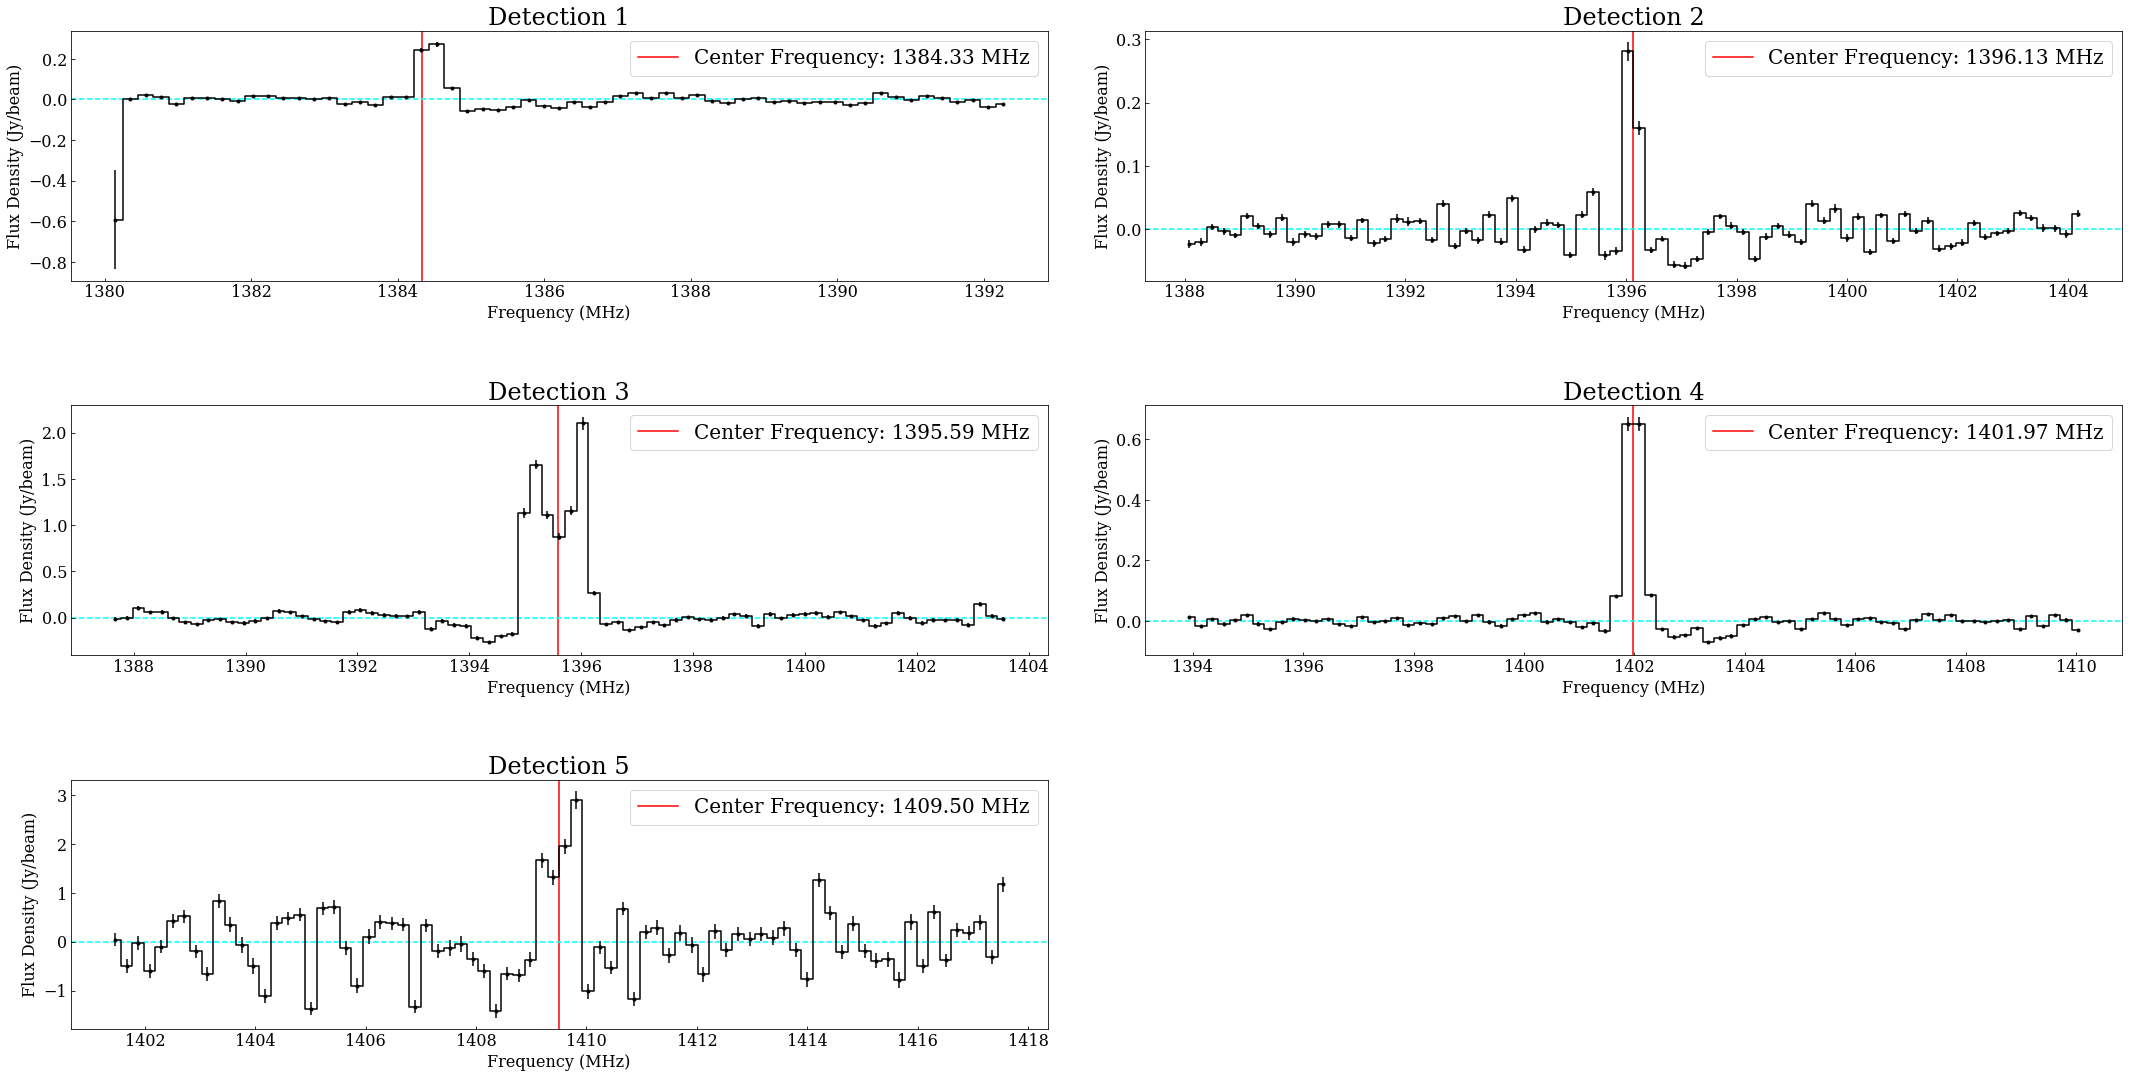

In [13]:
pl.figure(figsize=(30,20))

for i in range(len(detections)):
    pl.subplot(4,2,i+1)

    pl.step((freqs[i].to(u.MHz)).value, Sum[i].value, 'k', where='mid')
    pl.errorbar((freqs[i].to(u.MHz)).value, Sum[i].value, yerr=error[i].value, fmt='k.')
    pl.axvline(x=(center_freqs[i].to(u.MHz)).value, color='red', zorder=1, 
               label='Center Frequency: %.2f MHz'%(center_freqs[i].to(u.MHz)).value)
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('Detection '+str(i+1))
    pl.xlabel('Frequency (MHz)')
    pl.ylabel('Flux Density (Jy/beam)')
    pl.tight_layout()
    pl.legend()
pl.subplots_adjust(hspace=0.5)

Detection 1 has a low flux as a result of that data point being in the 0th channel, so let us delete it in all the arrays (only run this cell once!):

In [14]:
freqs[0] = np.delete(freqs[0], 0)
Sum[0] = np.delete(Sum[0], 0)
error[0] = np.delete(error[0], 0)
mean[0] = np.delete(mean[0], 0)
med[0] = np.delete(med[0], 0)
vel[0] = np.delete(vel[0], 0)

Plotting all the spectra again:

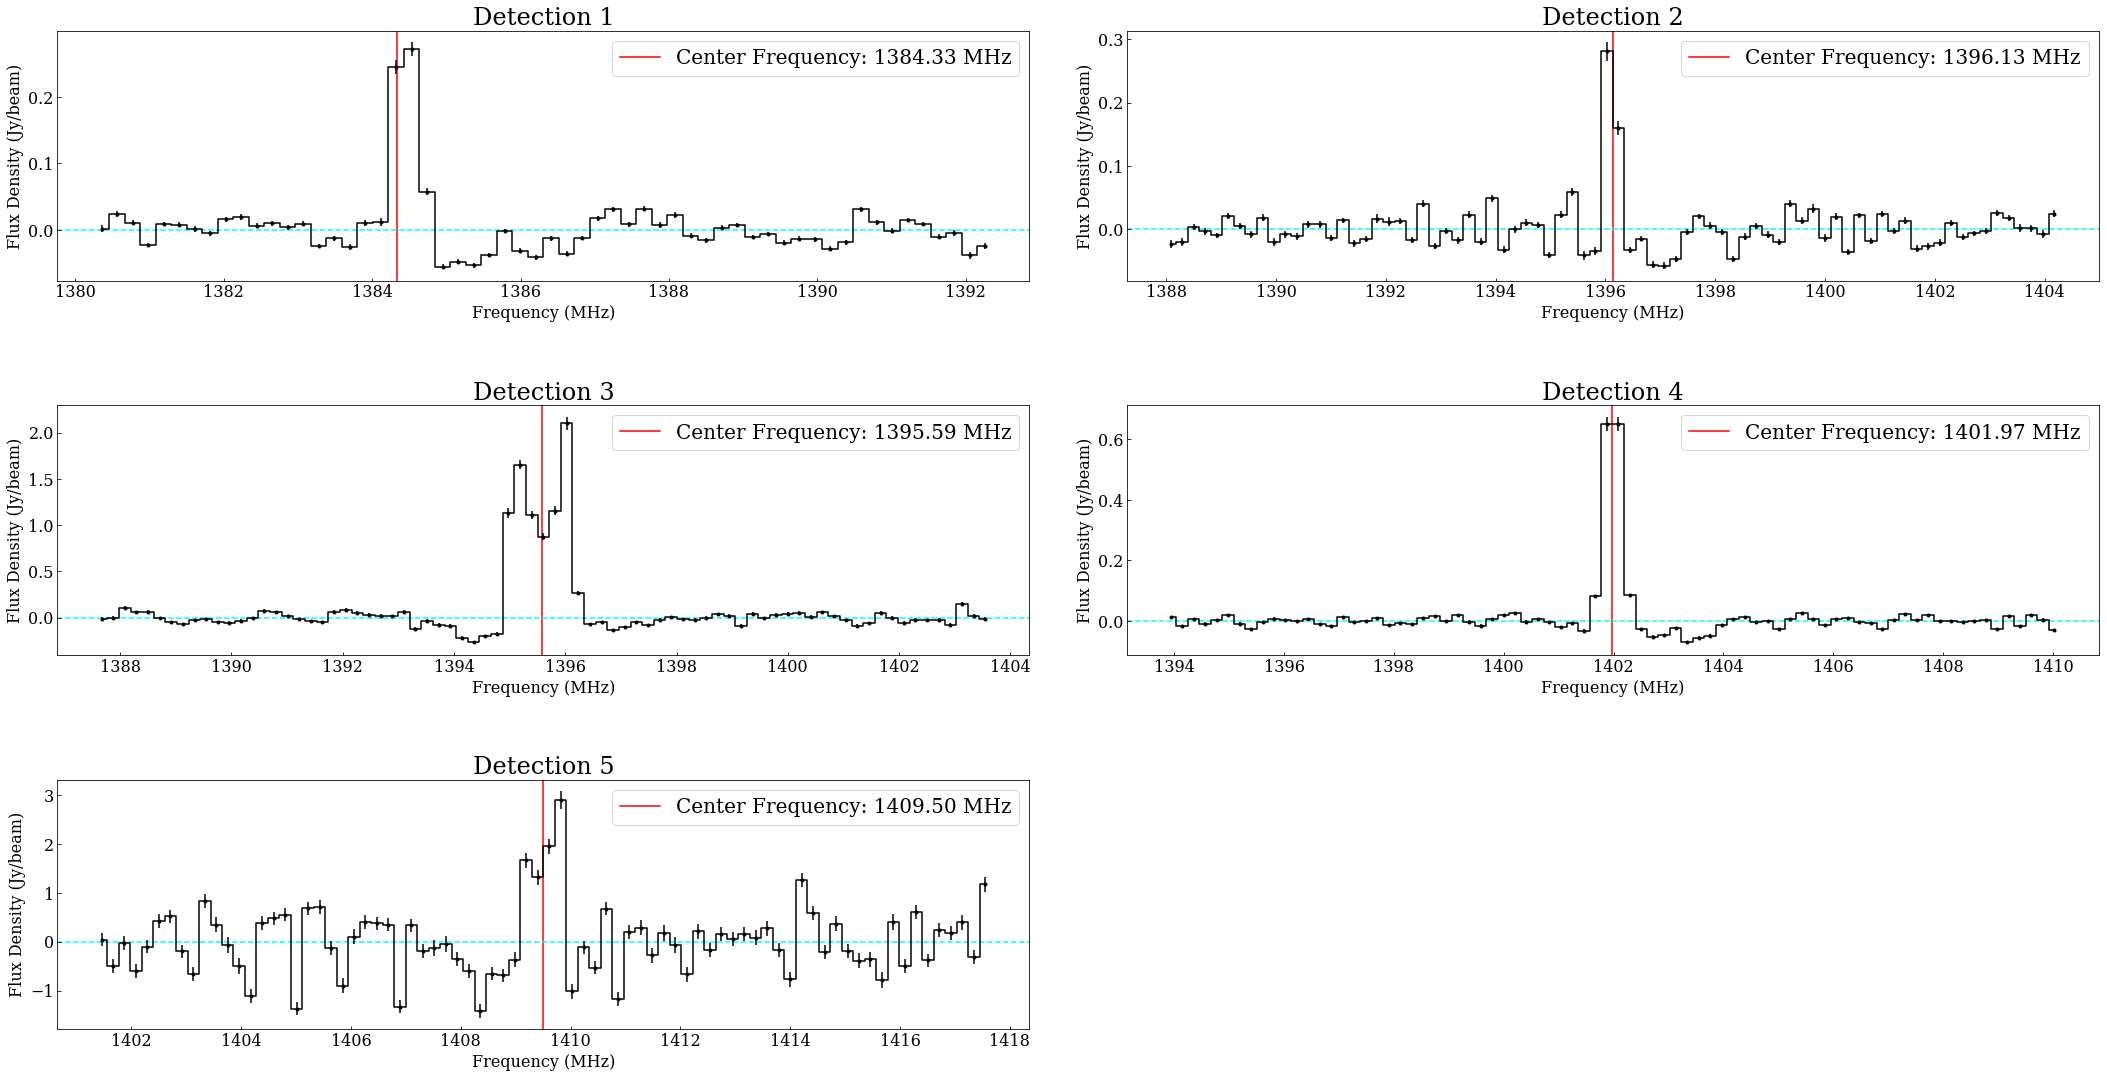

In [15]:
pl.figure(figsize=(30,20))

for i in range(len(detections)):
    pl.subplot(4,2,i+1)

    pl.step((freqs[i].to(u.MHz)).value, Sum[i].value, 'k', where='mid') 
    pl.errorbar((freqs[i].to(u.MHz)).value, Sum[i].value, yerr=error[i].value, fmt='k.')
    pl.axvline(x=(center_freqs[i].to(u.MHz)).value, color='red', zorder=1, 
               label='Center Frequency: %.2f MHz'%(center_freqs[i].to(u.MHz)).value)
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('Detection '+str(i+1))
    pl.xlabel('Frequency (MHz)')
    pl.ylabel('Flux Density (Jy/beam)')
    pl.tight_layout()
    pl.legend() 
pl.subplots_adjust(hspace=0.5)

# 6. Converting Jy/beam to Jy

To start doing the analysis on the spectra, we first need to convert the flux density in Jy/beam to Jy. The method behing this conversion is described in an excerpt from Meyer 2017:

![Conversion](jybeamconv.png)

$\Omega_B$ is the solid angle of the source and has the relation with the physical area given by

\begin{align}
\Omega_B = \frac{\pi b_\text{maj}b_{min}}{4\text{ln}2}, \\
\end{align}

in units of steradians (radians squared) or m$^2$m$^{-2}$. In our case, we will work in arcseconds squared.

In [21]:
# A function that converts Jy/beam to Jy
def jybeam_jy(subcube_list, sum_list):
    '''
    subcube_list is the list of subcubes
    sum_list is the list of sum flux densities in Jy/beam
    '''
    # List to store the fluxes in Jy for each detection
    jy_list = []
    
    # Loop through each detection
    for i in range(len(subcube_list)):
        # List to store Jy for each channel
        jy = [] 
        
        # Take into account outlier in detection 1 that was deleted
        if i != 0:
            # Loop through each channel
            for j in range(len(subcube_list[i])):
                # Calculate the solid angle or beam (omegaB) in arcsec squared
                # Jy/beam * beam = Jy/pixel_area
                bmaj = subcube_list[i][j].beam.major.value
                bmin = subcube_list[i][j].beam.minor.value

                omegaB = (np.pi*bmaj*bmin)/(4*np.log(2))

                # Calculate the pixel area in arcsec squared
                # Jy/pixel * pixel_area = Jy
                # CDELT1 and CDELT2 have the same magnitudes in degrees, so CDELT2 will be used since CDELT2 > 0
                pix_area = pow((subcube_list[i].header['CDELT2']*3600),2)

                jy.append(sum_list[i][j].value*(pix_area/omegaB))
            
            jy_list.append(np.array(jy)*u.Jy)
            
        else:
            # Loop through each channel
            for j in range(len(subcube_list[i])-1):
                # Calculate the solid angle or beam (omegaB) in arcsec squared
                # Jy/beam * beam = Jy/pixel_area
                bmaj = subcube_list[i][j].beam.major.value
                bmin = subcube_list[i][j].beam.minor.value

                omegaB = (np.pi*bmaj*bmin)/(4*np.log(2))

                # Calculate the pixel area in arcsec squared
                # Jy/pixel * pixel_area = Jy
                # CDELT1 and CDELT2 have the same magnitudes in degrees, so CDELT2 will be used since CDELT2 > 0
                pix_area = pow((subcube_list[i].header['CDELT2']*3600),2)

                jy.append(sum_list[i][j].value*(pix_area/omegaB))
            
            jy_list.append(np.array(jy)*u.Jy)
    
    return jy_list

In [22]:
flux = jybeam_jy(subcube, Sum)

To calculate the error in the flux we can use:

\begin{align}
u(\text{flux}) = \sqrt{\left(\text{flux}\frac{u(Sum)}{Sum}\right)^2}
\end{align}

In [23]:
# Calculate the error in the flux
flux_err = []

# Loop through each detection
for i in range(len(detections)):
    # Calculate the error in each channel
    err = []
    for j in range(len(flux[i])):
        err.append(flux[i][j].value*(error[i][j].value/Sum[i][j].value))
        
    flux_err.append(np.array(err)*u.Jy)

Plot the spectra in terms of flux in Jy:

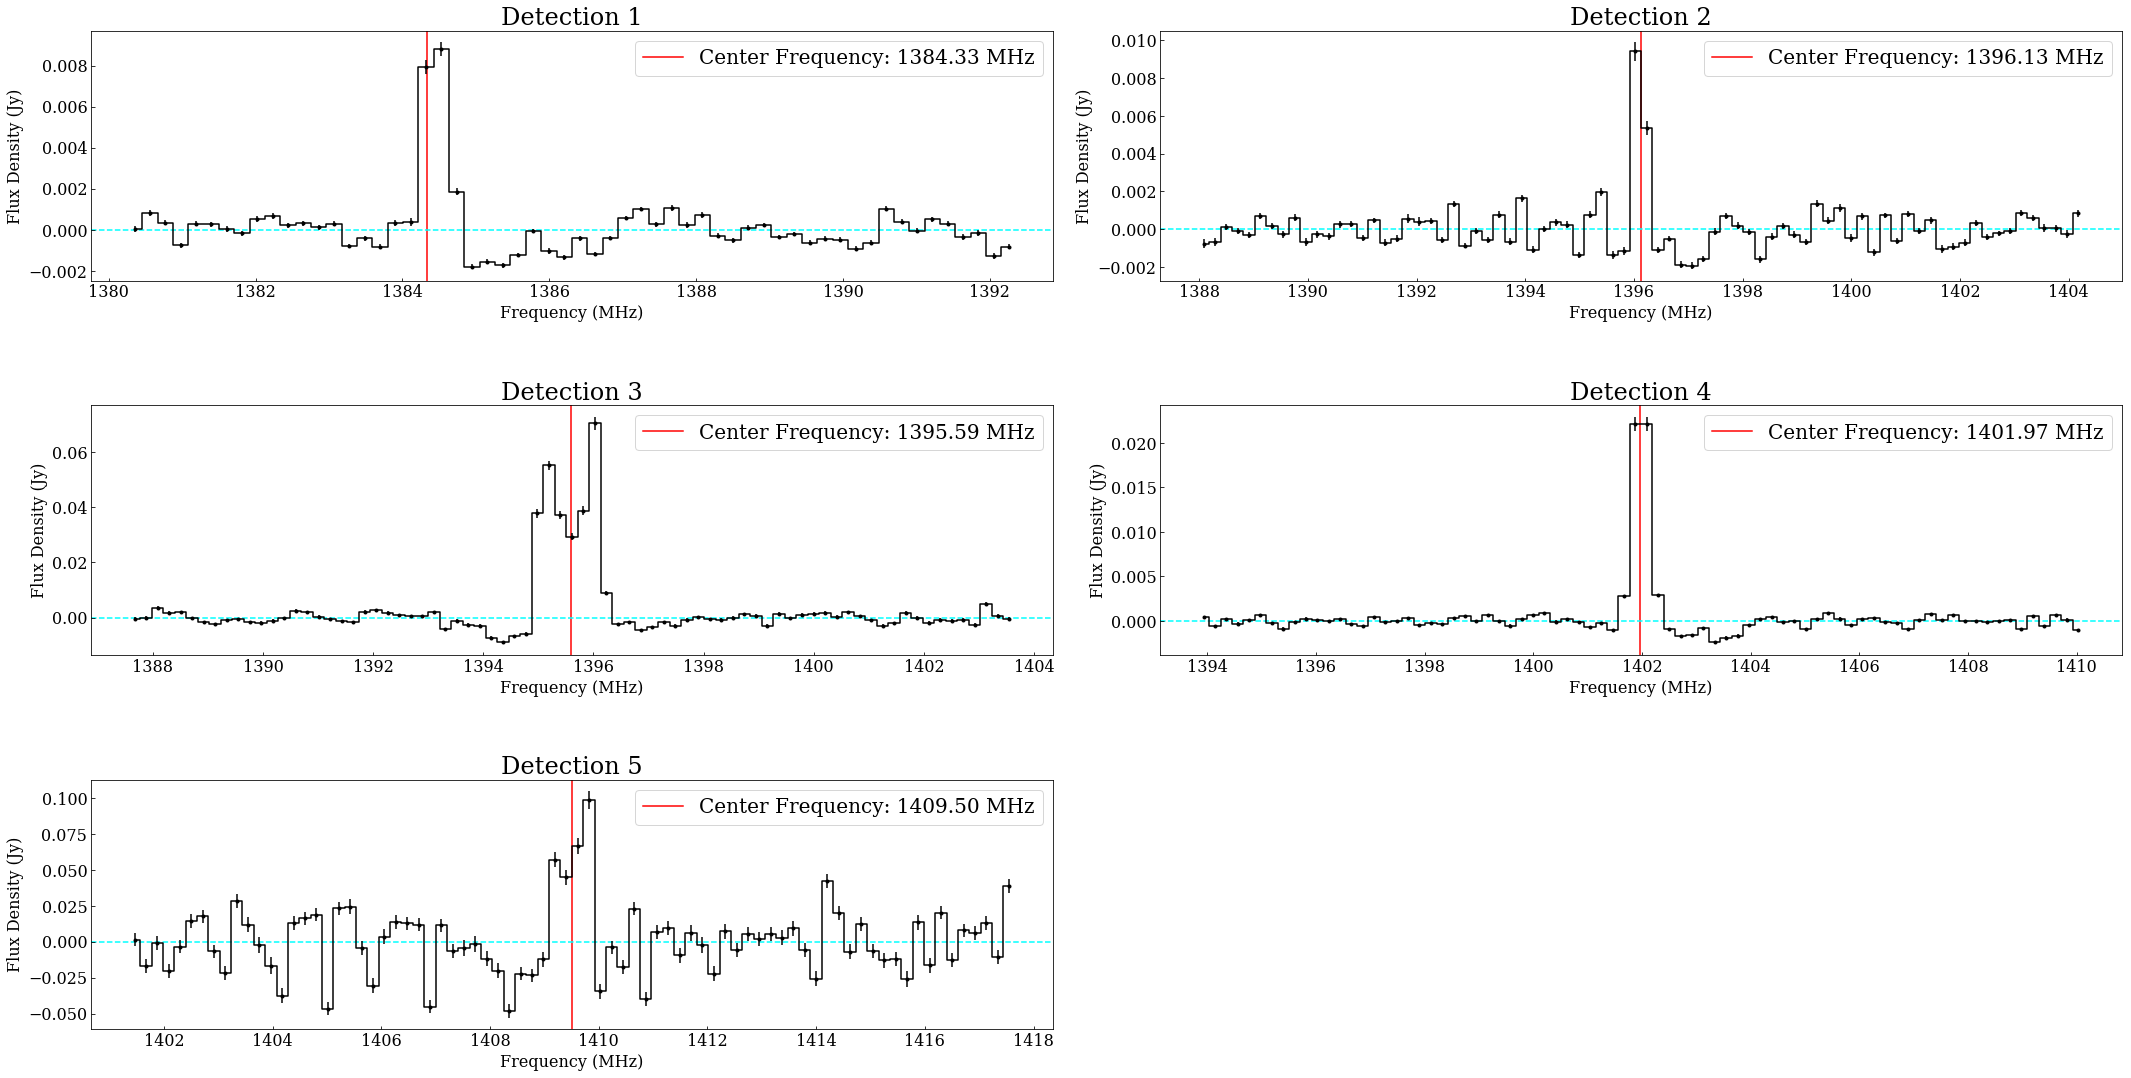

In [24]:
pl.figure(figsize=(30,20))

for i in range(len(detections)):
    pl.subplot(4,2,i+1)

    pl.step((freqs[i].to(u.MHz)).value, flux[i].value, 'k', where='mid') 
    pl.errorbar((freqs[i].to(u.MHz)).value, flux[i].value, yerr=flux_err[i].value, fmt='k.')
    pl.axvline(x=(center_freqs[i].to(u.MHz)).value, color='red', zorder=1, 
               label='Center Frequency: %.2f MHz'%(center_freqs[i].to(u.MHz)).value)
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('Detection '+str(i+1))
    pl.xlabel('Frequency (MHz)')
    pl.ylabel('Flux Density (Jy)')
    pl.tight_layout()
    pl.legend() 
pl.subplots_adjust(hspace=0.5)

# 7. Continuum Subtraction

From the profiles we can see that there are still some residual effects from having performed the continuum subtraction in CASA. To fix this and make sure that the continuum averages around zero, we have to fit a polynomial to the continuum, masking out the profile, to model what the continuum looks like, and then subtract the fit from the continuum.

## 7.1. Create a mask where the HI emission is
Note that since one channel is 208985.82 Hz wide, hence we are plotting the spectral as step function (i.e. for every 208985.82 Hz, we have one flux value), the bounds of the the emission need to lie at the centers of the step.

Note, the channel width was calculated using

In [25]:
dnu = freqs[0][1] - freqs[0][0]
dnu

<Quantity 208985.82463503 Hz>

To find out what the channel width is in terms of velocity, which will be useful later, one can either use the velocity list that was calculated in the subcube extraction using `with_spectral_unit`:

In [26]:
vel[0][30]-vel[0][31]

<Quantity 45.15407749 km / s>

Or by converting the frequencies directly into velocities, and then calculating the difference (which is essentially what `with_spectral_unit` does). However, the channel wdith varies slightly across each detection due to the relativistic conversion from frequencies to velocities, so we need to calculate the average channel width for each detection:

In [27]:
# List to store average channel widths in velocity space
dv_det = []

for i in range (len(detections)):
    dv_det.append(np.average(abs(np.diff(vel[i]))))

Back to creating the mask:

In [28]:
# Frequency limits for each of the detections
f_1a, f_1b = 1384.1, 1384.73
f_2a, f_2b = 1396.01, 1396.22
f_3a, f_3b = 1394.98, 1396.22
f_4a, f_4b = 1401.68, 1402.3
f_5a, f_5b = 1409.2, 1409.8

# Zip and store these limits in a tuple
f_limit = [[f_1a, f_1b],[f_2a, f_2b],[f_3a, f_3b],[f_4a, f_4b],[f_5a, f_5b]]
f_a, f_b = zip(*f_limit)

# Look for close matches to our limits in the data set
# Store these matches in lists
findex_a = []
findex_b = []
for i in range(len(detections)):
    x = freqs[i].to(u.MHz).value
    #rather than demand an exact match, should find the closest one
    findex_b.append(min(range(len(x)), key=lambda k: abs(x[k]-f_a[i]))-1)
    findex_a.append(min(range(len(x)), key=lambda k: abs(x[k]-f_b[i]))+1)

Plot the profiles to see if the chosen frequency bounds represent where the profiles are:

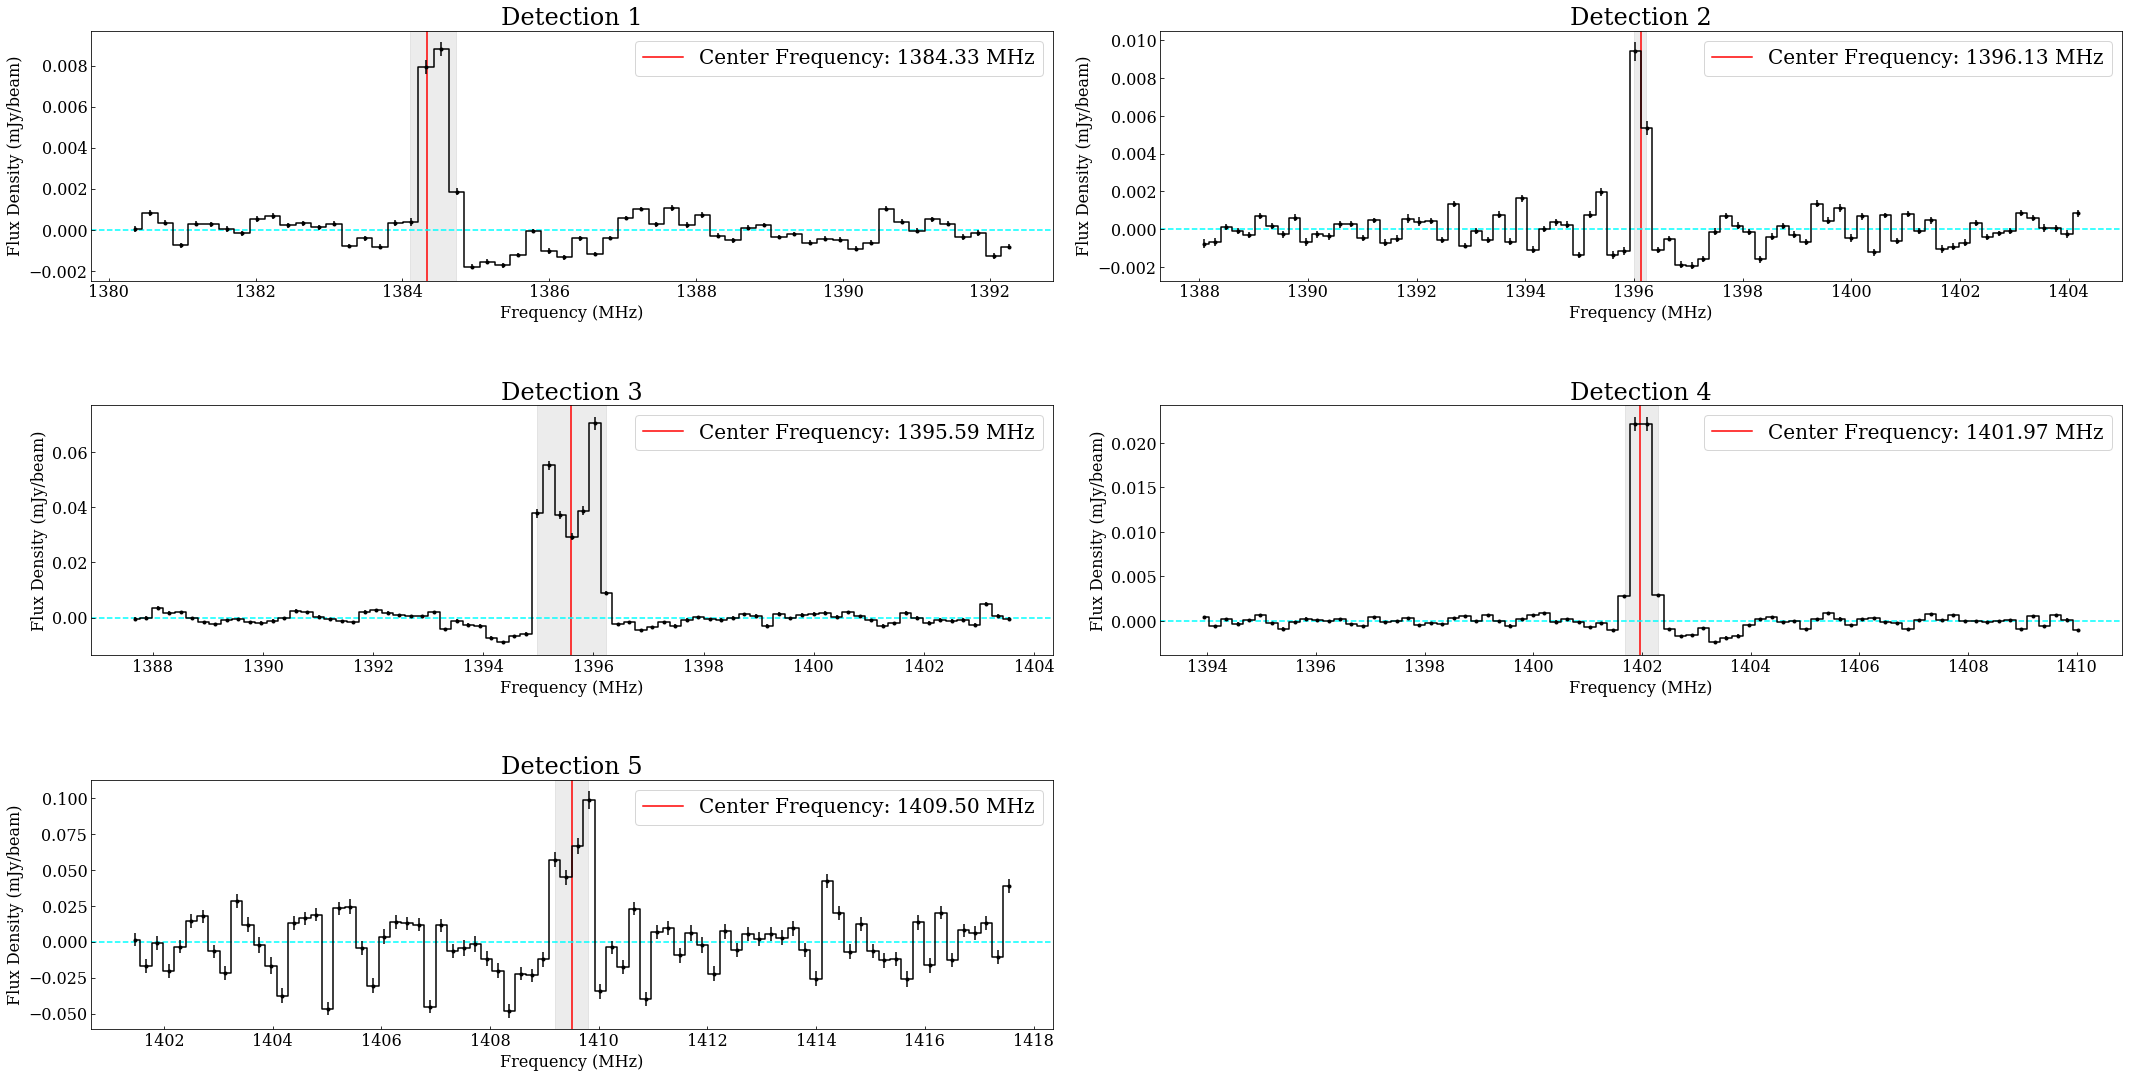

In [29]:
pl.figure(figsize=(30,20))

for i in range(len(detections)):
    pl.subplot(4,2,i+1)

    pl.step(freqs[i].to(u.MHz).value, flux[i].value, 'k', where='mid')  
    pl.errorbar((freqs[i].to(u.MHz)).value, flux[i].value, yerr=flux_err[i].value, fmt='k.')
    pl.axvline(x=(center_freqs[i].to(u.MHz)).value, color='red', zorder=1, 
               label='Center Frequency: %.2f MHz'%(center_freqs[i].to(u.MHz)).value)
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('Detection '+str(i+1))
    pl.xlabel('Frequency (MHz)')
    pl.ylabel('Flux Density (mJy/beam)')
    ax = pl.gca()
    ax.axvspan(f_a[i], f_b[i], alpha=0.15, color='grey')
    pl.tight_layout()
    pl.legend()
pl.subplots_adjust(hspace=0.5)

In [30]:
# Select the values outside the mask
continuum = [] # List to store values outside mask

for i in range(len(detections)):
    continuum.append((freqs[i].to(u.MHz).value < freqs[i].to(u.MHz).value[findex_b[i]]) | 
                     (freqs[i].to(u.MHz).value > freqs[i].to(u.MHz).value[findex_a[i]]))

## 7.2. Polynomial Fitting

We will now do polynomial fitting from orders 1 to 3 on all the spectra with the mask applied (regions where `continuum` is `True`.

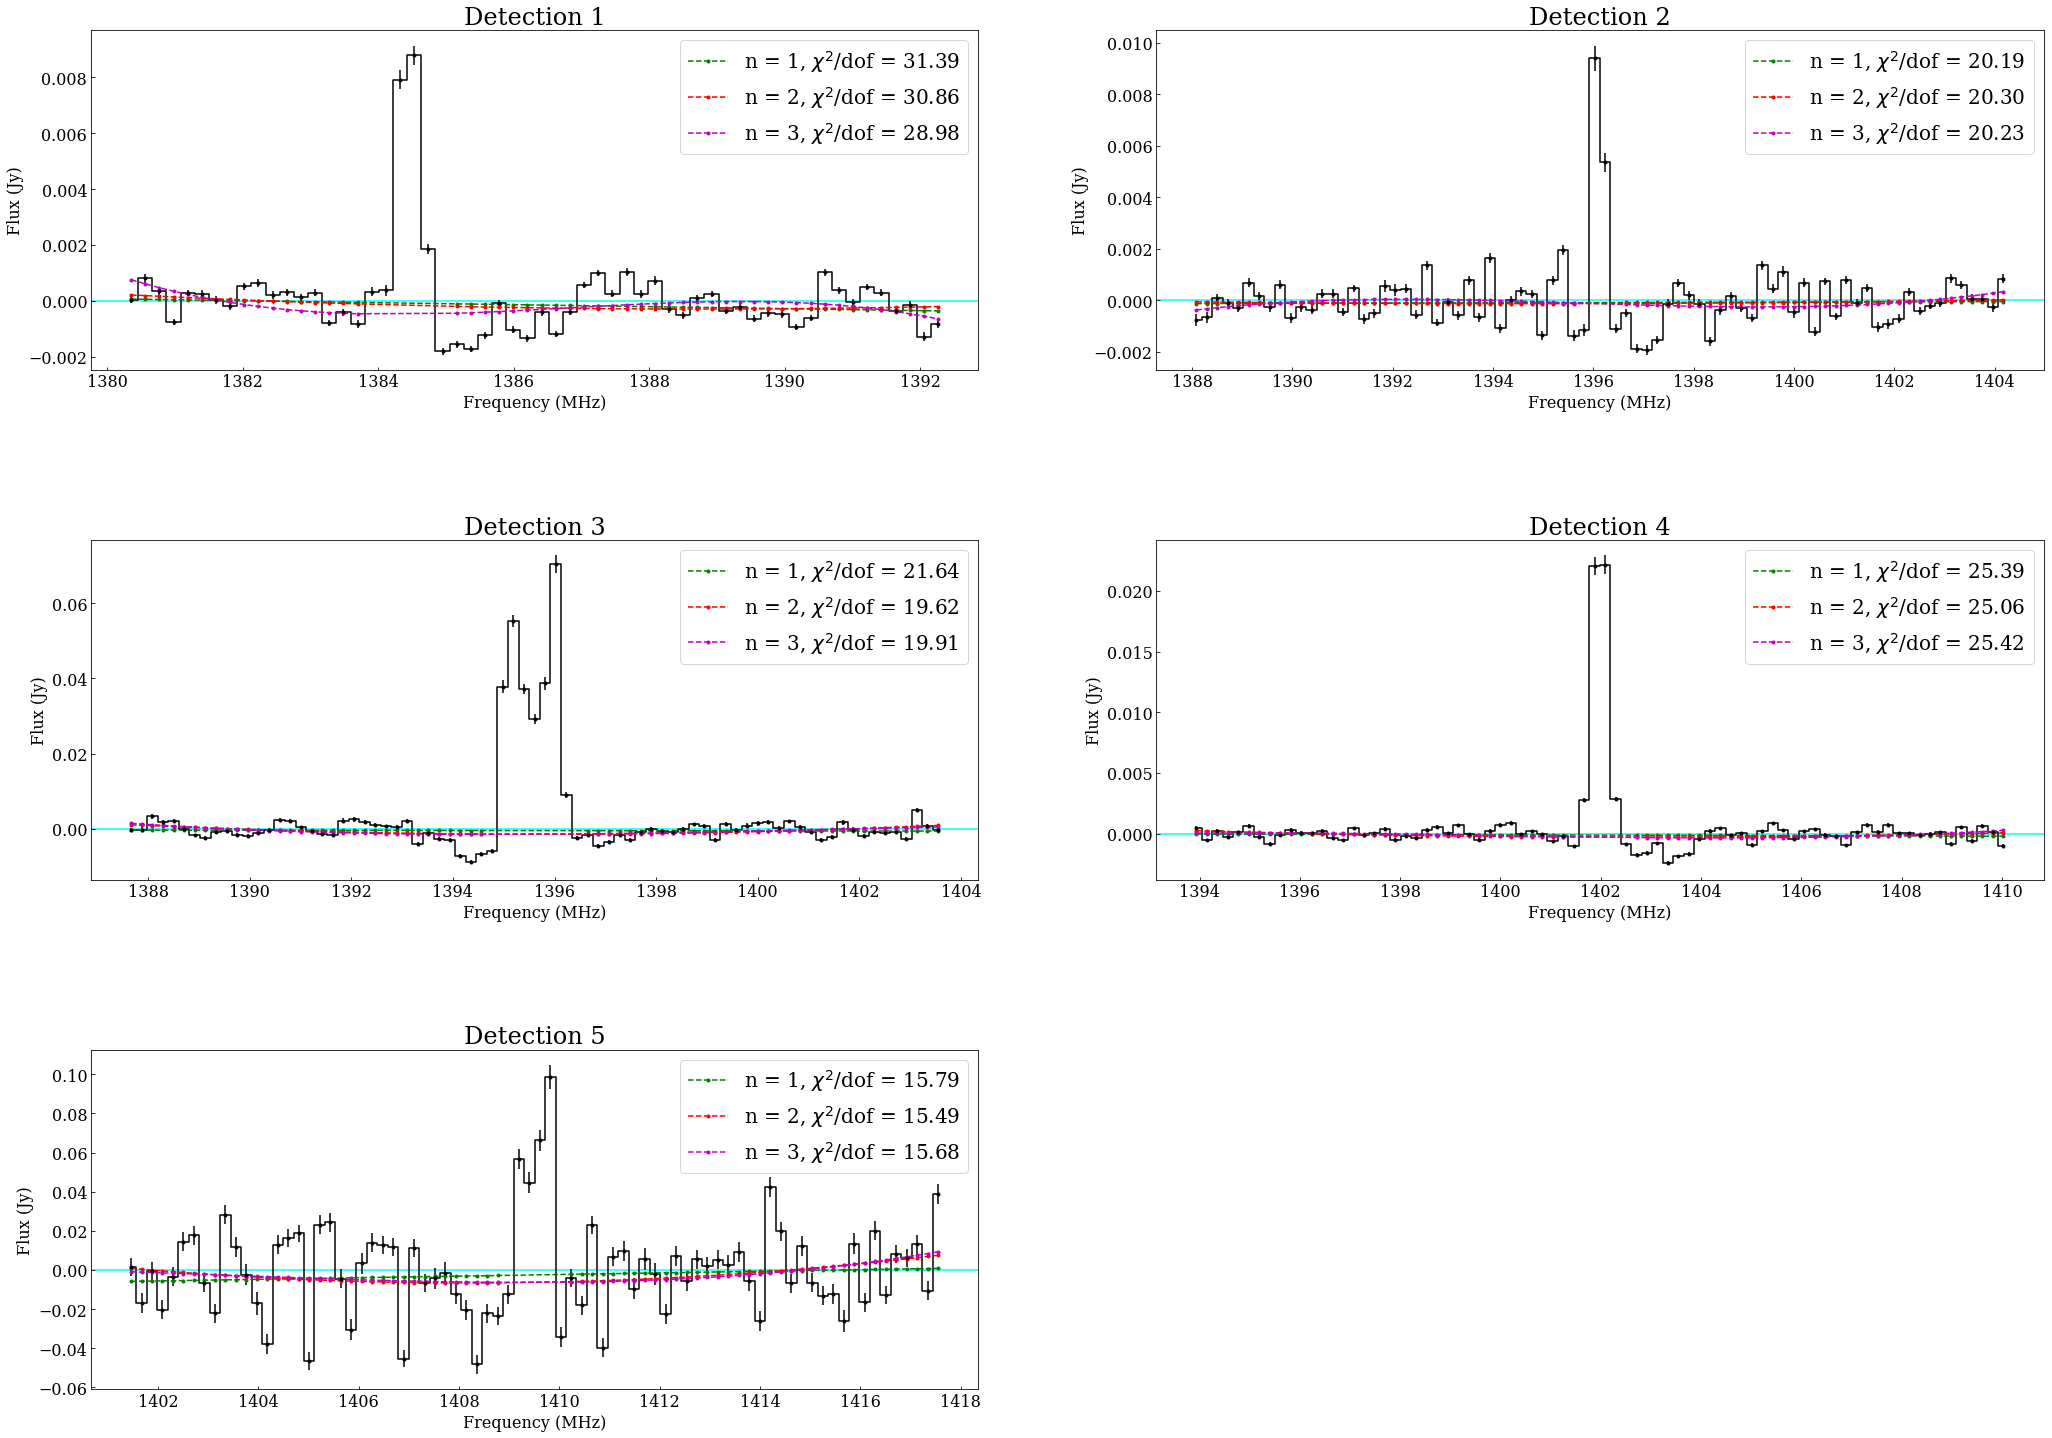

In [31]:
# Create lists to store the values
# fittedParameters are the constants polyfit returns
# modelPredictions are the y-values evaluated at each x using the constants attained from polyfit
# res_cont are the residuals (the sum of the squares of the uncertainties in a, b, c and d)
fittedParameters_cont1 = [] # Fitting order: 1 (value of ax + b)
modelPredictions_cont1 = [] # Evaluate the fitted parameters at each x where continuum == True
res_cont1 = [] # Residuals from the fit
fittedParameters_cont2 = [] # Fitting order: 2 (value of ax^2 + bx + c)
modelPredictions_cont2 = [] # Evaluate the fitted parameters at each x where continuum == True
res_cont2 = [] # Residuals from the fit
fittedParameters_cont3 = [] # Fitting order: 3 (value of ax^3 + bx^2 + cx + d)
modelPredictions_cont3 = [] # Evaluate the fitted parameters at each x where continuum == True
res_cont3 = [] # Residuals from the fit

# List to store the reduced chi squared values
red_chi1 = []
red_chi2 = []
red_chi3 = []

pl.figure(figsize=(35,25))

for i in range(len(detections)):
    # Do the fit on the continuum (i.e. only where continuum == True)
    # n = 1
    pol1, res1, _, _, _ = np.polyfit(freqs[i][continuum[i]].value, flux[i].value[continuum[i]], 1,
                                             w=flux_err[i][continuum[i]].value, full=True)
    fittedParameters_cont1.append(pol1)
    modelPredictions_cont1.append(np.polyval(fittedParameters_cont1[i], freqs[i][continuum[i]].value))
    res_cont1.append(res1)
    
    # Calculate the reduced chi for the fit
    red_chi1.append(np.sum(pow(modelPredictions_cont1[i] - flux[i].value[continuum[i]],2)/pow(flux_err[i][continuum[i]].value,2))/
                      (len(freqs[i][continuum[i]].value) - len(fittedParameters_cont1[i])))
    
    # n = 2
    pol2, res2, _, _, _ = np.polyfit(freqs[i][continuum[i]].value, flux[i].value[continuum[i]], 2,
                                             w = flux_err[i][continuum[i]].value, full=True)
    fittedParameters_cont2.append(pol2)
    modelPredictions_cont2.append(np.polyval(fittedParameters_cont2[i], freqs[i][continuum[i]].value))
    res_cont2.append(res2)
    
    # Calculate the reduced chi for the fit
    red_chi2.append(np.sum(pow(modelPredictions_cont2[i] - flux[i].value[continuum[i]],2)/pow(flux_err[i][continuum[i]].value,2))/
                      (len(freqs[i][continuum[i]].value) - len(fittedParameters_cont2[i])))
    
    # n = 3
    pol3, res3, _, _, _ = np.polyfit(freqs[i][continuum[i]].value, flux[i].value[continuum[i]], 3,
                                             w = flux_err[i][continuum[i]].value, full=True)
    fittedParameters_cont3.append(pol3)
    modelPredictions_cont3.append(np.polyval(fittedParameters_cont3[i], freqs[i][continuum[i]].value))
    res_cont3.append(res3)
    
    # Calculate the reduced chi for the fit
    red_chi3.append(np.sum(pow(modelPredictions_cont3[i] - flux[i].value[continuum[i]],2)/pow(flux_err[i][continuum[i]].value,2))/
                      (len(freqs[i][continuum[i]].value) - len(fittedParameters_cont3[i])))
    
    # Plot the profiles as well as the fits
    pl.subplot(3,2,i+1)
    pl.step(freqs[i].to(u.MHz).value, flux[i].value, 'k', where='mid') 
    pl.errorbar((freqs[i].to(u.MHz)).value, flux[i].value, yerr=flux_err[i].value, fmt='k.')
    
    # Polynomial fits
    pl.plot(freqs[i].to(u.MHz).value[continuum[i]],modelPredictions_cont1[i],'g--.', 
            label=r'n = 1, $\chi^2$/dof = %.2f'%red_chi1[i])
    pl.plot(freqs[i].to(u.MHz).value[continuum[i]],modelPredictions_cont2[i],'r--.', 
            label=r'n = 2, $\chi^2$/dof = %.2f'%red_chi2[i])
    pl.plot(freqs[i].to(u.MHz).value[continuum[i]],modelPredictions_cont3[i],'m--.', 
            label=r'n = 3, $\chi^2$/dof = %.2f'%red_chi3[i])
    
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='-')
    pl.title('Detection '+str(i+1))
    pl.xlabel('Frequency (MHz)')
    pl.ylabel('Flux (Jy)')
    pl.tick_params(which='major', direction='in')
    pl.legend()
    
pl.subplots_adjust(hspace=0.5)

Since none of the polynomials fit the continua with a $\chi^2$/dof $\approx 1$, as expected since the polynonials will under-fit the data, we will have to choose orders that best describes the continua, i.e. orders with a $\chi^2$/dof closest to $1$.

In [41]:
model_no = [] # List to store the order of the models for each detection

# Loop through each detection
for i in range(len(detections)):
    # Store each order's value in a list
    chi_n1 = red_chi1[i]
    chi_n2 = red_chi2[i]
    chi_n3 = red_chi3[i]
    chi_list = [chi_n1, chi_n2, chi_n3]
    
    # Check to see which polynomial fit has a reduced chi squared closest to 1
    min_chi = min(range(len(chi_list)), key=lambda i: abs(chi_list[i] - 1))
    model_no.append(min_chi + 1)

In [42]:
# List to store the model predictions
modelPredictions = []

# List to store the corresponding residuals
cont_res = []

for i in range(len(detections)):
    if model_no[i] == 1:
        modelPredictions.append(modelPredictions_cont1[i])
        cont_res.append(res_cont1[i])
        
    elif model_no[i] == 2:
        modelPredictions.append(modelPredictions_cont2[i])
        cont_res.append(res_cont2[i])
        
    elif model_no[i] == 3:
        modelPredictions.append(modelPredictions_cont3[i])
        cont_res.append(res_cont3[i])

We must now add zeros where the profiles are to make the `modelPredictions` sub-arrays the same sizes as the `freqs` and `sum_arr` sub-arrays (only run this line once!):

In [43]:
# Loop through each detection
for i in range(len(detections)):
    # The number of zeros to add  
    n = findex_a[i] - findex_b[i] + 1
    modelPredictions[i] = np.insert(modelPredictions[i], findex_b[i], n*[0])

To calculate what propagation in error to use for the flux density, we already know that by calling `np.polyfit` with `full = True`, it outputs the residuals (which are the sum of the squares of the error terms). In other words, if $ y = ax + b$, then $u(y) = \sqrt{u(a)^2 + u(b)^2}$, where $u(a)^2 + u(b)^2$ is what is known as the residual of $y$. So the uncertainty in the continuum subtracted fluxes ($\text{cont_sub} = \text{flux} - \text{y_poly}$) are

\begin{align}
u(\text{cont_sub}) &= \sqrt{u(\text{flux})^2 + u(\text{y_poly})^2} \\
 &= \sqrt{u(\text{flux})^2 + \sqrt(\text{residuals})^2} \\
 &= \sqrt{u(\text{flux})^2 + \text{residuals}}
\end{align}

Back to the continuum subtraction...

In [44]:
# Continuum subtraction
# List to store list of continuum subtracted fluxes
cont_sub = []

# List to store the errors in the continuum subtracted spectra
cont_sub_err = []

# Loop through each detection
for i in range(len(detections)):
    # List to store flux density values for each detection
    br = []
    # List to store errors for each detection
    err = []
    for j in range(len(flux[i])):
        # Calculate the errors based on equation in cell above
        err.append(np.sqrt(pow(flux_err[i][j].value,2) + cont_res[i][0]))
        
        # Perform the continuum subtraction where the continuum is
        if continuum[i][j] == True:
            br.append(flux[i][j].value - modelPredictions[i][j])
            
        # Select the same flux density values where the profile is
        else:
            br.append(flux[i][j].value)
            
    cont_sub.append(np.array(br)*u.Jy)
    cont_sub_err.append(np.array(err)*u.Jy)

Plot the profiles to see the result of performing continuum subtraction:

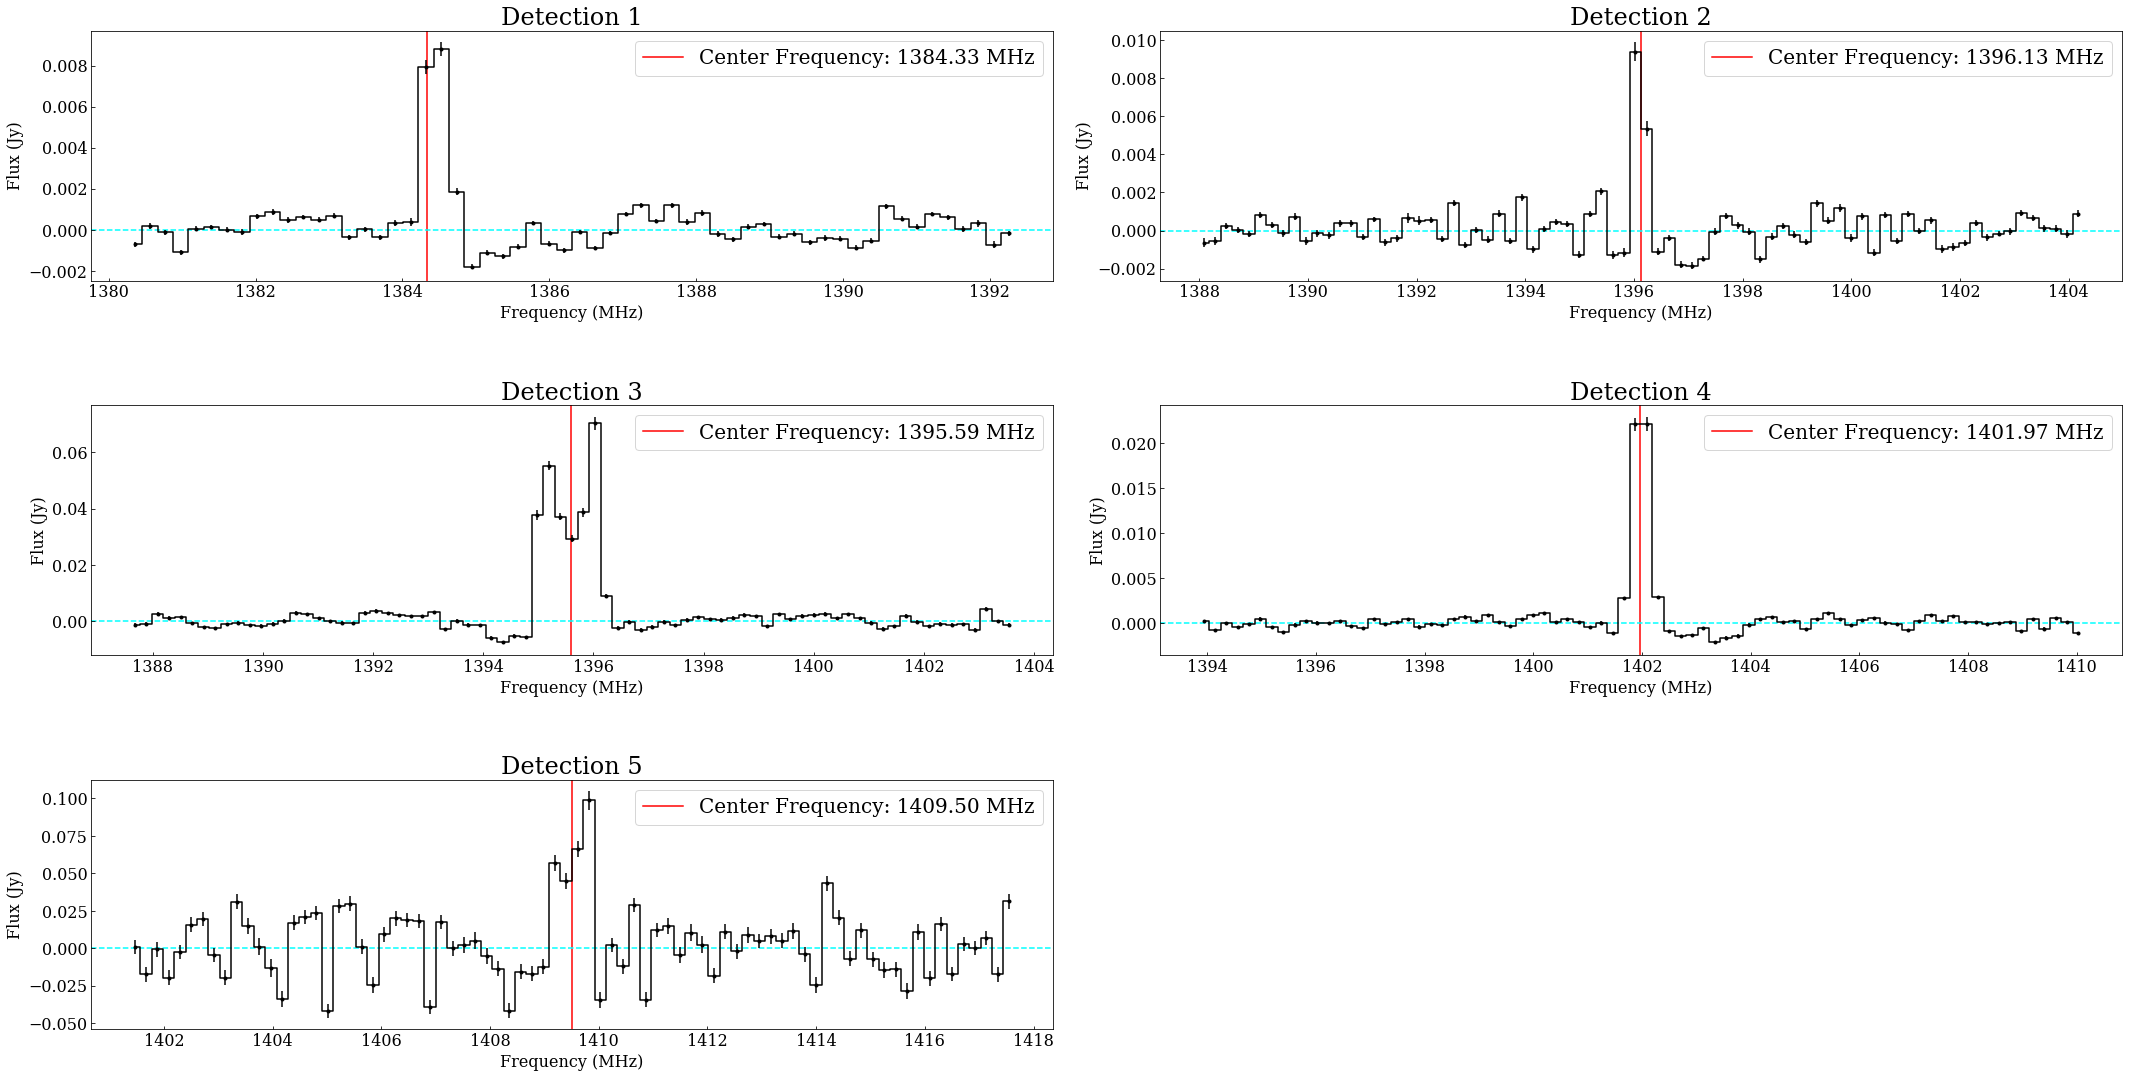

In [64]:
pl.figure(figsize=(30,20))

for i in range(len(detections)):
    pl.subplot(4,2,i+1)

    pl.step((freqs[i].to(u.MHz)).value, cont_sub[i].value, 'k', where='mid') 
    pl.errorbar((freqs[i].to(u.MHz)).value, cont_sub[i].value, yerr=cont_sub_err[i].value, fmt='k.')
    pl.axvline(x=(center_freqs[i].to(u.MHz)).value, color='red', zorder=1, 
               label='Center Frequency: %.2f MHz'%(center_freqs[i].to(u.MHz)).value)
    pl.axhline(y=0, color='cyan', zorder=1, linestyle='--')
    pl.tick_params(which='major', direction='in')
    pl.title('Detection '+str(i+1))
    pl.xlabel('Frequency (MHz)')
    pl.ylabel('Flux (Jy)')
    pl.tight_layout()
    pl.legend()
pl.subplots_adjust(hspace=0.5)

# 8. Data Analysis

The following analyisis is based on the the equations in Meyer (2017) and notes found here: https://www.cv.nrao.edu/course/astr534/HILine.html 

## 8.1. Systemic velocities, Hubble distances and redshifts
We need to calculate the systemic velocity using the rest frame motions (i.e. the motions of objects through space; this is the peculiar velocity)

\begin{align}
V(z) = c\frac{\nu_0^2 - \nu^2}{\nu_0^2 + \nu^2}.
\end{align}

It is not advised to use $V = cz = c\frac{\nu_0 - \nu}{\nu}$ because the deviations from this linear law become increasingly larger. The uncertaintity can be calculated using

\begin{align}
u(R) = \sqrt{\sum_{i=1}^N \left(u(w_i)\frac{\partial f}{\partial w_i}\right)^2},
\end{align}

where in our case

\begin{align}
\frac{\partial f}{\partial w_i} &= \frac{\partial V}{\partial \nu} = -\frac{4c\nu_0^2\nu}{(\nu^2 + \nu_0^2)^2}.
\end{align}

Therefore

\begin{align}
u(V) = \sqrt{\left(-u(\nu)\frac{4c\nu_0^2\nu}{(\nu^2 + \nu_0^2)^2}\right)^2}.
\end{align}

In [48]:
# Defining a function used for converting an observed frequency (Ghz) into velocity (km/s) for 21 cm emission
def radial_vel(obs_freq):
    '''
    obs_freq is the observed frequency of the emitted line in Ghz
    nu_o is the rest/emitted frequency in GHz
    v_opt is returned in km/s
    '''
    nu_0 = (hdulist[0].header['RESTFRQ']*u.Hz).to(u.GHz)
    v_opt = (const.c*pow(10,-3))*((pow(nu_0,2) - pow(obs_freq, 2))/(pow(nu_0,2) + pow(obs_freq, 2)))
    return v_opt

# Calculate the systemic velocities
central_vel = [radial_vel(cfreq) for cfreq in center_freqs]
    
# Calculate the uncertainties using above formula
vel_unc = []
for i in range(len(detections)):
    un = np.sqrt(pow((-dnu.to(u.GHz)*4*(const.c*pow(10,-3))*pow((hdulist[0].header['RESTFRQ']*u.Hz).to(u.GHz),2)*center_freqs[i])/
                     (pow((pow(center_freqs[i],2) + pow((hdulist[0].header['RESTFRQ']*u.Hz).to(u.GHz),2)),2)),2))
    
    vel_unc.append(un)

# Display the velocities
for i in range(len(central_vel)):
    print("Detection %d: %.2f +\- %.2f km/s"%(int(i+1),central_vel[i].value,vel_unc[i].value))

Detection 1: 7710.85 +\- 45.23 km/s
Detection 2: 5167.44 +\- 44.86 km/s
Detection 3: 5284.46 +\- 44.88 km/s
Detection 4: 3916.32 +\- 44.68 km/s
Detection 5: 2310.62 +\- 44.45 km/s


One can calculate the redshifts to the galaxies using $z=\frac{\nu_0-\nu}{\nu}=\frac{\nu_0}{\nu}-1$, and approximate the uncertainties in $z$ using the derivative formula above:

\begin{align}
u(z) &= \sqrt{\left(u(z)\frac{\partial z}{\partial \nu}\right)^2} \\
 &= \sqrt{\left[u(\nu)\left(-\frac{\nu_0}{\nu^2}\right)\right]^2} \\
 &= \sqrt{\left[u(\nu)\left(-\frac{\nu_0}{\nu^2}\right)\right]^2} \\
 &= -\frac{u(\nu)\nu_0}{\nu^2} \\
\end{align}

In [49]:
# Function to calculate the redshift
def calc_z(obs_freq):
    '''
    obs_freq is the observed frequency of the emitted line in Ghz
    nu_o is the rest/emitted frequency in GHz
    z is the returned redshift
    '''
    nu_0 = (hdulist[0].header['RESTFRQ']*u.Hz).to(u.GHz)
    z = (nu_0 - obs_freq)/obs_freq
    return z

# Calculate the redshifts
z = [calc_z(center_freqs[i]) for i in range(len(detections))]
    
# Calculate the uncertainties in z
#unc_z = [z[i]*np.sqrt(pow(dnu/(hdr[0].header['RESTFRQ']*u.Hz),2) + pow(dnu/center_freqs[i].to(u.Hz),2)) for i in range(len(detections))]
unc_z = [(dnu.to(u.GHz)*(hdulist[0].header['RESTFRQ']*u.Hz).to(u.GHz))/pow(v,2) for v in center_freqs]
    
# Display the redshifts
for i in range(len(z)):
    print("Detection %d: %.6f +\- %.6f"%(int(i+1),z[i],unc_z[i]))

Detection 1: 0.026060 +\- 0.000155
Detection 2: 0.017388 +\- 0.000152
Detection 3: 0.017785 +\- 0.000152
Detection 4: 0.013150 +\- 0.000151
Detection 5: 0.007737 +\- 0.000149


One can estimate the Hubble distance using the equation $D \approx \frac{V}{H_0}$, where $V$ is the systemic velocity calculated from the central frequency, and $H_0 = 67.4 \pm 0.54$ km s$^{-1}$ Mpc$^{-1}$. $u(D)$ can be calculated using: 

\begin{align}
u(D) &= D\sqrt{\left(\frac{u(V)}{V}\right)^2 + \left((-1)\frac{u(H_0)}{H_0}\right)^2} \\
\end{align}

In [50]:
unc_H0 = 0.54*u.km/u.s/u.Mpc # Uncertainty in the Hubble constant https://arxiv.org/pdf/1807.06209.pdf
H0 = 67.4*u.km/u.s/u.Mpc

# Function to calculate the hubble distance
def hubble_dist(v_r, H0):
    '''
    v_r is the central velocity of the detection in km/s
    '''
    return v_r/H0

# Calculate the hubble distances
D = [hubble_dist(val, H0) for val in central_vel]
    
# Calculate the uncertainty in D
unc_D = [D[i]*np.sqrt(pow(dv_det[i]/central_vel[i],2) + pow(unc_H0/H0,2)) for i in range(len(detections))]


# Display the Hubble distances
for i in range(len(D)):
    print("Detection %d: %.3f +\- %.3f Mpc"%(int(i+1),D[i].value,unc_D[i].value))

Detection 1: 114.404 +\- 0.670 Mpc
Detection 2: 76.668 +\- 0.666 Mpc
Detection 3: 78.404 +\- 0.666 Mpc
Detection 4: 58.106 +\- 0.663 Mpc
Detection 5: 34.282 +\- 0.659 Mpc


## 8.2. HI Mass
In order to calculate the HI mass $M_\text{HI}$, we need to use the formula

\begin{equation}
\left(\frac{M_\text{HI}}{\text{M}_\odot}\right) \approx \frac{2.36 \times 10^5}{(1+z)^2} \left(\frac{D}{\text{Mpc}}\right)^2 \int\left[\frac{S(\nu)}{\text{Jy}}\right]\left(\frac{dv}{\text{km/s}}\right) \\
\end{equation}

where $\int S(\nu)dv$ over the line is called the line flux and is in units of Jy km $\text{s}^{-1}$. However, we need only calculate the HI mass of the detection and not the whole spectrum. So let us define the limits of the profile, where the x-values are now in terms of velocity (km/s) and not frequency (MHz). However, since we already found the limits in terms of frequencies, we can flip `index_a` and `index_b` for the velocities.

In [67]:
index_a = findex_b
index_b = findex_a

In [82]:
def hi_mass_vel(hubble_D, S, z, vel_array, vel_lower, vel_upper, v_diff):
    '''
    hubble_D is the list of hubble distances in Mpc
    S is the list of fluxes in Jy
    vel_arr is the array of velocities for each subcube in km/s
    vel_lower is the list of lower limits for each profile
    vel_upper is the list of upper limits for each profile
    v_diff is the channel width in terms of velocity
    '''
    HI_mass = [] # List to store Mhi for each detection
    HI_mass_err = [] # List to store errors in Mhi
    line_flux = [] # List to store the line fluxes in km/s
    line_flux_err = [] # List to store errors in line fluxes
    
    # Loop through each data cube
    for i in range(len(detections)):
        
        Sdv = 0 # Initialise line flux
        
        # Loop through data in each cube to calculate the line flux
        for j in range(vel_lower[i], vel_upper[i]+1):
            # Velocity width
            dv = v_diff[i].value
            
            # Calculate the integral
            Sdv += S[i][j].value*dv
            
        line_flux.append(Sdv*u.Jy*u.km/u.s)
        
        # Calculate the error in the line flux 
        # Flux from off-emission channels
        off_flux = np.array(S[i].value[0:vel_lower[i]].tolist() + S[i].value[vel_upper[i]:-1].tolist())
        
        # Calculate the std deviation of off-emission channels
        std_off_flux = np.std(off_flux)
        
        # Error in integrated flux
        line_err = (std_off_flux*np.sqrt(len(S[i]))*v_diff[i].value)
        line_flux_err.append(line_err*u.Jy*u.km/u.s)
            
        # Calculate the HI mass for this current detection
        M = ((2.35*(10**5))/pow(1+z[i],2))*pow(hubble_D[i].value,2)*Sdv
        HI_mass.append(M*u.M_sun)
        
        # Calculate the HI mass error
        M_err = ((2.35*(10**5))/pow(1+z[i],2))*pow(hubble_D[i].value,2)*line_err
        HI_mass_err.append(M_err*u.M_sun)
        
    return HI_mass, HI_mass_err, line_flux, line_flux_err

In [83]:
HI_mass1380_vel, HI_mass1380_vel_err, line_jykms, line_jykms_err = hi_mass_vel(D, cont_sub, z, vel, index_a, index_b, dv_det)

[str(round(math.log(HI_mass1380_vel[i].value, 10),3))+' +/- '+str(round(0.434*HI_mass1380_vel_err[i].value/HI_mass1380_vel[i].value, 3)) 
 for i in range(len(HI_mass1380_vel))]

['9.362 +/- 0.128',
 '8.874 +/- 0.243',
 '10.227 +/- 0.032',
 '9.219 +/- 0.051',
 '9.424 +/- 0.328']

In [84]:
[str(round(line_jykms[i].value ,3))+' +/- '+str(round(line_jykms_err[i].value, 3)) 
 for i in range(len(line_jykms))]

['0.789 +/- 0.232',
 '0.561 +/- 0.315',
 '12.081 +/- 0.889',
 '2.142 +/- 0.25',
 '9.759 +/- 7.373']

The HI Mass can also be calculated using

\begin{align}
\left(\frac{M_\text{HI}}{\text{M}_\odot}\right) \approx 49.7\left(\frac{D}{\text{Mpc}}\right)^2\int\left[\frac{S(\nu)}{\text{Jy}}\right]\left(\frac{d\nu}{\text{Hz}}\right)
\end{align}

In [94]:
def hi_mass_freq(hubble_D, S, freq_array, freq_lower, freq_upper, freq_width):
    '''
    hubble_D is the list of hubble distances in Mpc
    S is the list of fluxes in Jy
    freq_arr is the array of frequencies for each subcube in Hz
    freq_lower is the list of lower limits for each profile
    freq_upper is the list of upper limits for each profile
    freq_width is the channel width in frequency space
    '''
    HI_mass = [] # List to store Mhi for each detection
    HI_mass_err = [] # List to store errors in Mhi
    line_flux = [] # List to store the line fluxes in Jy Hz
    line_flux_err = [] # List to store errors in line fluxes
    
    # Loop through each data cube
    for i in range(len(detections)):
        
        Sdv = 0 # Initialise line flux
        # Loop through data in each cube to calculate the line flux
        for j in range(freq_lower[i], freq_upper[i]+1):        
            # Calculate the integral
            Sdv += S[i][j].value*freq_width.value
            
        line_flux.append(Sdv*u.Jy*u.Hz)
        
        # Calculate the error in the line flux 
        # Flux from off-emission channels
        off_flux = np.array(S[i].value[0:freq_lower[i]].tolist() + S[i].value[freq_upper[i]:-1].tolist())
        
        # Calculate the std deviation of off-emission channels
        std_off_flux = np.std(off_flux)
        
        # Error in integrated flux
        line_err = (std_off_flux*np.sqrt(len(S[i]))*freq_width.value)
        line_flux_err.append(line_err*u.Jy*u.Hz)
            
        # Calculate the HI mass for this current detection
        M = 49.7*pow(hubble_D[i].value,2)*Sdv
        HI_mass.append(M*u.M_sun)
        
        # Calculate the HI mass error
        M_err = 49.7*pow(hubble_D[i].value,2)*line_err
        HI_mass_err.append(M_err*u.M_sun)
        
    return HI_mass, HI_mass_err, line_flux, line_flux_err

In [99]:
HI_mass1380_freq, HI_mass1380_freq_err, line_jyhz, line_jyhz_err = hi_mass_freq(D, cont_sub, freqs, findex_b, findex_a, dnu)

['('+str(round(math.log(HI_mass1380_freq[i].value, 10),3))+' +/- '+str(round(0.434*HI_mass1380_freq_err[i].value/HI_mass1380_freq[i].value, 3)) 
 +') Msol' for i in range(len(HI_mass1380_freq))]

['(9.375 +/- 0.128) Msol',
 '(8.883 +/- 0.243) Msol',
 '(10.235 +/- 0.032) Msol',
 '(9.226 +/- 0.051) Msol',
 '(9.428 +/- 0.328) Msol']

In [100]:
['('+str(round(line_jyhz[i].value*1e-4 ,3))+' +/- '+str(round(line_jyhz_err[i].value*1e-4, 3))+') x 10^4 Jy Hz' 
 for i in range(len(line_jykms))]

['(0.365 +/- 0.107) x 10^4 Jy Hz',
 '(0.261 +/- 0.147) x 10^4 Jy Hz',
 '(5.626 +/- 0.414) x 10^4 Jy Hz',
 '(1.002 +/- 0.117) x 10^4 Jy Hz',
 '(4.588 +/- 3.467) x 10^4 Jy Hz']

## 8.3. $W_{20}$ and $W_{50}$

To find the width at $20\%$ and $50\%$, we have to decipher if the profile is double horned or not, and based on that, we can find the widths. Since the data from this particular cube is very low resolution, the best width to calculate is $W_{50}$, else we would be reaching into the noise of the profile.

The busy function is defined as

\begin{align}
B(x) = \frac{a}{4}[\text{erf}(b_1\{w+x-x_e\})+1]\times[\text{erf}(b_2\{w-x+x_e\})+1]\times [c|x-x_p|^n+1], \\
\end{align}

where $\text{erf}(x) = \frac{2}{\sqrt{\pi}}\int^x_0\text{exp}(-t^2)\text{d}t$ is the gaussian error function, $a$ is the scaling factor, $b_1$ and $b_2$ the steepness of the line flanks, $w$ the half-width of the profile, $x_e$ and $x_p$ the centroid of the error functions/polynomial, $c$ the scaling factor of the polynomial trough, and $n$ the order of the polynomial (see https://www.astron.nl/phiscc2014/Documents/Techniques/Westmeier_Busy_Function_phiscc2014.pdf for more details). The diagram below further illustrates the different parameters.

![Busy Function](BF.png)

In [101]:
# Define the busy function
def B(x, a, b1, b2, w, xe, xp, c, n):
    '''
    x is the list of x-values
    a is the scaling factor
    b1 is the steepness of the first flank
    b2 is the steepness of the second flank
    w is half the FWHM
    xe is the center of the error function
    xp is the center of the polynomial
    c is the scaling factor of the polynomial trough
    n is the order of the polynomial
    '''
    return (a/4.)*(sp.special.erf(b1*(w+x-xe))+1)*(sp.special.erf(b2*(w-x+xe))+1)*(c*pow(abs(x-xp),n)+1)

Before doing the busy function fitting, let us first define a function to calculate $W_{20}$ and $W_{50}$ based off of the fit (manually calculating $W_{50}$ will be useful for comparing it to the $W_{50}$ from the fit parameters):

In [102]:
# w function
def calc_w(x, y, w, ind_diff):
    '''
    x is the list of np.linspace velocities
    y is the busy function applied to x with the popt parameters
    w is which width needs to be calculated: 50% or 20%
    ind_diff is the minimum difference between the first and the second index
    '''
    # Calculate 20% or 50% of the max
    max_per = (w/100)*max(y) 

    # Select the indices and values greater than zero
    indzero = np.where(y > 0)
    valzero = y[indzero[0][0]:indzero[0][-1]+1]
    vel = x[indzero[0][0]:indzero[0][-1]+1] # Corresponding velocities

    # Calculate the difference between the values and max20
    diff = abs(valzero - max_per)

    # Find the first 20 smallest differences
    # 20 to make sure that the values chosen aren't on the same flank
    small = heapq.nsmallest(20, diff)

    # Get their indices in diff
    indsmall = [np.where(diff == v)[0][0] for v in small]

    # Select one index corresponding to the left flank and one corresponding to the right flank
    wind = []
    for i in range(len(indsmall)):
        for index in indsmall:
            if abs(indsmall[i] - index) > ind_diff:
                wind.append(indsmall[i])
                wind.append(index)
                break
        else:
            continue  # only executed if the inner loop did NOT break
        break  # only executed if the inner loop DID break

    # Calculate w
    W = abs(vel[wind[0]] - vel[wind[1]])
    
    return W, max_per, wind, vel, valzero

Following Saintonge (2007) and Cortese et al. (2008), the signal-to-noise ratio is derived by:

\begin{align}
\mathrm{SNR} = \left(\frac{S^V \sqrt{w}}{\sigma_\mathrm{rms} \times W_{50}}\right),
\end{align}

where w is given by $W_{50}/(2dv)$ for $W_{50}$ less than $400$ km s$^{-1}$, or $(400 \mathrm{km s}^{-1})/(2dv)$ for $W_{50} \geq 400 \mathrm{km s}^{-1})$; $S^V$ is the line flux in Jy km s$^{-1}$; and $\sigma_\mathrm{rms}$ is the theoretical flux in Jy.

Following Schneider 1990, $u(W_{50}) = 3.0(W_{20}-W_{50})/\mathrm{SNR}$ and $u(W_{20}) = 4.7(W_{20}-W_{50})/\mathrm{SNR}$.

### 8.3.1. Detection 1

In [103]:
i = 0
# Initial guesses for detection 1
a_1, b1_1, b2_1, w_1, xe_1, xp_1, c_1, n_1 = max(cont_sub[i].value), 0.03, 0.03, 50, central_vel[i].value, central_vel[i].value, 1e-12, 2

# Store the guesses in a list
det1_guess = [a_1, b1_1, b2_1, w_1, xe_1, xp_1, c_1, n_1]

# Use scipy to perform the busy function fit
popt1, pcov1 = curve_fit(B, vel[i].value[index_a[i]-1:index_b[i]+3], cont_sub[i].value[index_a[i]-1:index_b[i]+3], 
                         p0=det1_guess, sigma=cont_sub_err[i].value[index_a[i]-1:index_b[i]+3], absolute_sigma=True, 
                         bounds=((0, 0, 0, 30, 7500, 7500, 0, 2),(np.inf, np.inf, np.inf, 70, 7795, 7795, np.inf, 8)), 
                         maxfev=10000)

popt1

array([8.75739020e-03, 9.49476422e-02, 4.71830846e-02, 5.16938546e+01,
       7.67999802e+03, 7.68791894e+03, 9.31118985e-06, 2.00185854e+00])

To see whether the fit is good, we need to perform a $\chi^2$ test:

In [104]:
i = 0
# Calculate the chi^2/dof
# f(x)
Bx = B(vel[i].value[index_a[i]-1:index_b[i]+3], popt1[0], popt1[1], popt1[2], popt1[3], popt1[4], popt1[5], popt1[6], popt1[7])

# y
y = cont_sub[i].value[index_a[i]-1:index_b[i]+3]

# sum(f(x) - y)^2
chi = np.sum(pow(Bx - y,2)/pow(cont_sub_err[i].value[index_a[i]-1:index_b[i]+3],2))

# Degrees of freedom
dof = len(vel[i][index_a[i]-1:index_b[i]+3]) - len(popt1)

print("min chi/dof", chi/dof)

min chi/dof 449.0933157000897


In [105]:
i = 0
# Calculate the values based on the parameters
x_val_1 = np.linspace(min(vel[i].value), max(vel[i].value), 10000)
y_val_1 = B(x_val_1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4], popt1[5], popt1[6], popt1[7])

In [106]:
# Calculate W50
W50fit_1 = 2*popt1[3] 
W50calc_1, l50_1, ind50_1, vel_50_1, flux50_1 = calc_w(x_val_1, y_val_1, 50, 50)

# Calculate W20
W20_1, l20_1, ind20_1, vel_20_1, flux20_1 = calc_w(x_val_1, y_val_1, 20, 50)

In [107]:
i = 0
# Calculate the SNR
meanrms1 = np.mean(flux_err[i][index_a[i]:index_b[i]+3]).value # calculate the average rms over the line for this detection 

SNR1 = (line_jykms[i].value*np.sqrt(W50calc_1/(2*dv_det[i].value)))/(meanrms1*W50calc_1)

# Calculate the error in w20
uW20_1 = 3*(W20_1 - W50calc_1)/SNR1

# Calculate the error in w50
uW50_1 = 4.7*(W20_1 - W50calc_1)/SNR1

In [108]:
i = 0
print('W20 = %.2f +/- %.2f km/s'%(W20_1, (np.sqrt(pow(uW20_1,2) +pow(dv_det[i].value/2,2)))))
print()
print('W50 from fit = %.2f +/- %.2f km/s'%(W50fit_1, (np.sqrt(pow(uW50_1,2) + pow(dv_det[i].value/2,2)))))
print('W50 from function = %.2f +/- %.2f km/s'%(W50calc_1, uW50_1))

W20 = 122.56 +/- 22.62 km/s

W50 from fit = 103.39 +/- 22.68 km/s
W50 from function = 103.76 +/- 2.12 km/s


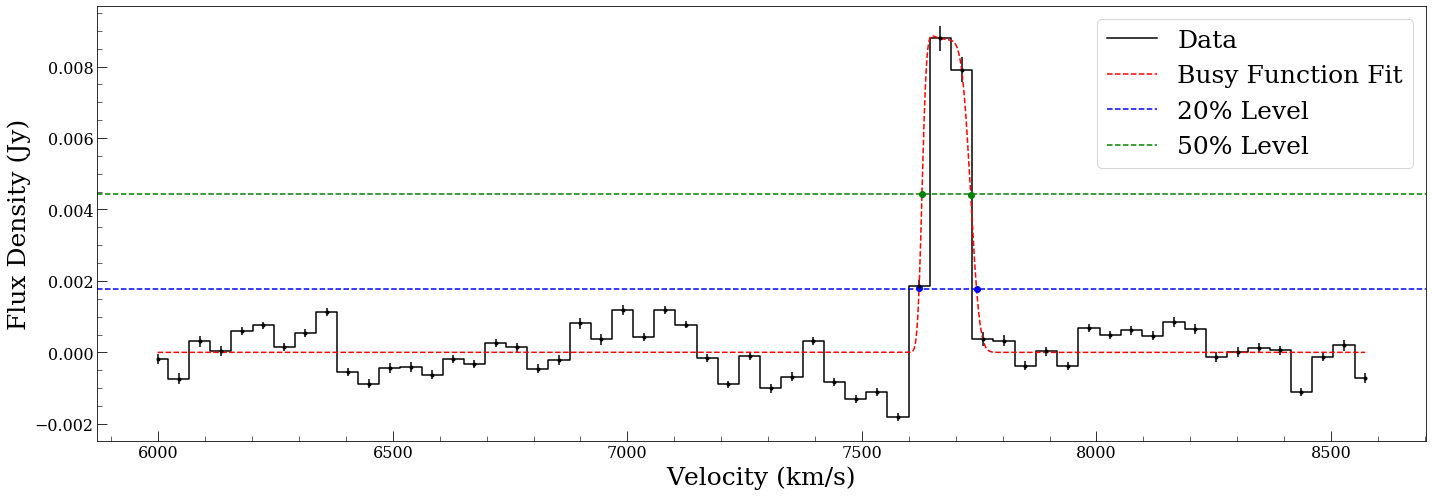

In [109]:
i = 0
# Plot the results
pl.figure(figsize=(20,7))

# The data
pl.step(vel[i].value, cont_sub[i].value, 'k', where='mid', label='Data')
pl.errorbar(vel[i].value, cont_sub[i].value, yerr=cont_sub_err[i].value, fmt='k.')

# The busy function fit
pl.plot(x_val_1, y_val_1, 'r--', label='Busy Function Fit')

# 20% level
pl.plot(vel_20_1[ind20_1[0]], flux20_1[ind20_1[0]], 'bo')
pl.plot(vel_20_1[ind20_1[1]], flux20_1[ind20_1[1]], 'bo')
pl.axhline(y=l20_1, color='b', linestyle='--', label=r'20% Level')

# 50% level
pl.plot(vel_50_1[ind50_1[0]], flux50_1[ind50_1[0]], 'go')
pl.plot(vel_50_1[ind50_1[1]], flux50_1[ind50_1[1]], 'go')
pl.axhline(y=l50_1, color='g', linestyle='--', label=r'50% Level')

pl.gca().xaxis.set_minor_locator(AutoMinorLocator())
pl.gca().yaxis.set_minor_locator(AutoMinorLocator())
pl.tick_params(which='major', direction='in', length=10)
pl.tick_params(which='minor', direction='in', length=5)
pl.xlabel('Velocity (km/s)', fontsize=25)
pl.ylabel('Flux Density (Jy)', fontsize=25)
pl.tight_layout()
pl.legend(fontsize=25)

#### 8.3.2. Detection 2

In [110]:
i = 1
# Initial guesses for detection 2
a_2, b1_2, b2_2, w_2, xe_2, xp_2, c_2, n_2 = max(cont_sub[i].value), 0.03, 0.03, 20, central_vel[i].value, central_vel[i].value, 1e-12, 2

# Store the guesses in a list
det2_guess = [a_2, b1_2, b2_2, w_2, xe_2, xp_2, c_2, n_2]

# Use scipy to perform the busy function fit
popt2, pcov2 = curve_fit(B, vel[i].value[index_a[i]-2:index_b[i]+4], cont_sub[i].value[index_a[i]-2:index_b[i]+4], 
                         p0=det2_guess, sigma=cont_sub_err[i].value[index_a[i]-2:index_b[i]+4], absolute_sigma=True, 
                         bounds=((0, 0, 0, 10, 4850, 4850, 0, 2),(np.inf, np.inf, np.inf, 50, 5300, 5300, np.inf, 8)), 
                         maxfev=10000)

popt2

array([1.80863519e-02, 9.65922024e-02, 7.39656394e-02, 2.06121851e+01,
       5.16972053e+03, 5.16812813e+03, 2.33979069e-05, 2.00000000e+00])

To see whether the fit is good, we need to perform a $\chi^2$ test:

In [111]:
i = 1
# Calculate the chi^2/dof
# f(x)
Bx = B(vel[i].value[index_a[i]-2:index_b[i]+4], popt2[0], popt2[1], popt2[2], popt2[3], popt2[4], popt2[5], popt2[6], popt2[7])

# y
y = cont_sub[i].value[index_a[i]-2:index_b[i]+4]

# sum(f(x) - y)^2
chi = np.sum(pow(Bx - y,2)/pow(cont_sub_err[i].value[index_a[i]-2:index_b[i]+4],2))

# Degrees of freedom
dof = len(vel[i][index_a[i]-2:index_b[i]+4]) - len(popt2)

print("min chi/dof", chi/dof)

min chi/dof 418.80085646788325


In [112]:
i = 1
# Calculate the values based on the parameters
x_val_2 = np.linspace(min(vel[i].value), max(vel[i].value), 10000)
y_val_2 = B(x_val_2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4], popt2[5], popt2[6], popt2[7])

In [113]:
# Calculate W50
W50fit_2 = 2*popt2[3] 
W50calc_2, l50_2, ind50_2, vel_50_2, flux50_2 = calc_w(x_val_2, y_val_2, 50, 50)

# Calculate W20
W20_2, l20_2, ind20_2, vel_20_2, flux20_2 = calc_w(x_val_2, y_val_2, 20, 50)

In [114]:
i = 1
# Calculate the SNR
meanrms2 = np.mean(flux_err[i][index_a[i]-1:index_b[i]+3]).value # calculate the average rms over the line for this detection 

SNR2 = (line_jykms[i].value*np.sqrt(W50calc_2/(2*dv_det[i].value)))/(meanrms2*W50calc_2)

# Calculate the error in w20
uW20_2 = 3*(W20_2 - W50calc_2)/SNR2

# Calculate the error in w50
uW50_2 = 4.7*(W20_2 - W50calc_2)/SNR2

In [115]:
i = 1
print('W20 = %.2f +/- %.2f km/s'%(W20_2, (np.sqrt(pow(uW20_2,2) +pow(dv_det[i].value/2,2)))))
print()
print('W50 from fit = %.2f +/- %.2f km/s'%(W50fit_2, (np.sqrt(pow(uW50_2,2) + pow(dv_det[i].value/2,2)))))
print('W50 from function = %.2f +/- %.2f km/s'%(W50calc_2, uW50_2))

W20 = 55.97 +/- 22.46 km/s

W50 from fit = 41.22 +/- 22.51 km/s
W50 from function = 41.80 +/- 1.89 km/s


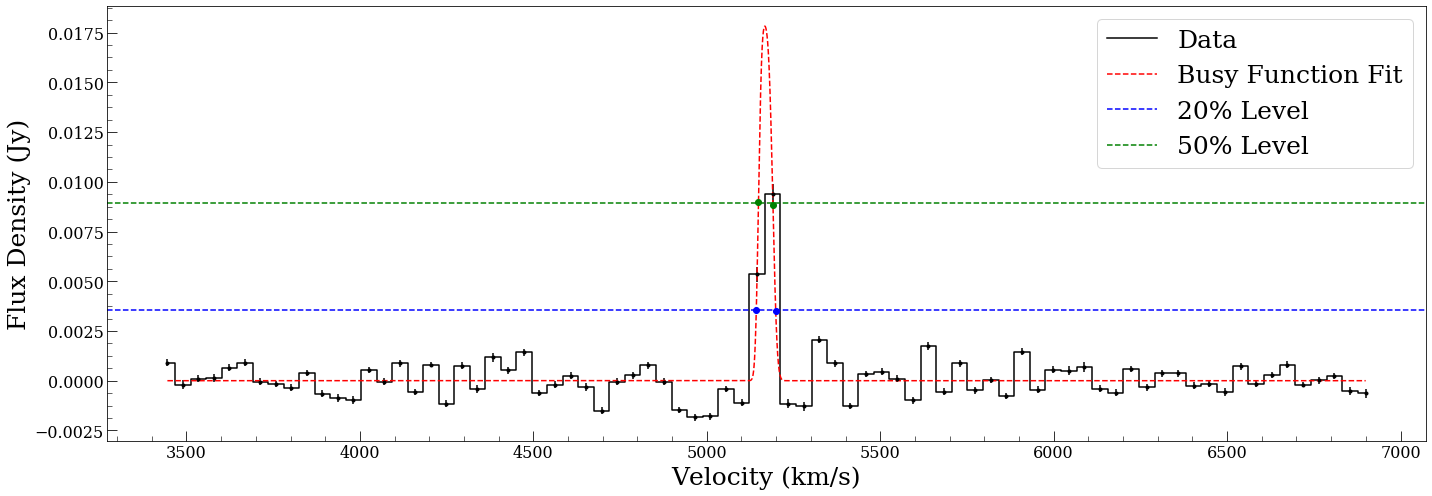

In [116]:
i = 1
# Plot the results
pl.figure(figsize=(20,7))

# The data
pl.step(vel[i].value, cont_sub[i].value, 'k', where='mid', label='Data')
pl.errorbar(vel[i].value, cont_sub[i].value, yerr=cont_sub_err[i].value, fmt='k.')

# The busy function fit
pl.plot(x_val_2, y_val_2, 'r--', label='Busy Function Fit')

# 20% level
pl.plot(vel_20_2[ind20_2[0]], flux20_2[ind20_2[0]], 'bo')
pl.plot(vel_20_2[ind20_2[1]], flux20_2[ind20_2[1]], 'bo')
pl.axhline(y=l20_2, color='b', linestyle='--', label=r'20% Level')

# 50% level
pl.plot(vel_50_2[ind50_2[0]], flux50_2[ind50_2[0]], 'go')
pl.plot(vel_50_2[ind50_2[1]], flux50_2[ind50_2[1]], 'go')
pl.axhline(y=l50_2, color='g', linestyle='--', label=r'50% Level')

pl.gca().xaxis.set_minor_locator(AutoMinorLocator())
pl.gca().yaxis.set_minor_locator(AutoMinorLocator())
pl.tick_params(which='major', direction='in', length=10)
pl.tick_params(which='minor', direction='in', length=5)
pl.xlabel('Velocity (km/s)', fontsize=25)
pl.ylabel('Flux Density (Jy)', fontsize=25)
pl.tight_layout()
pl.legend(fontsize=25)

#### 8.3.3. Detection 3

In [117]:
i = 2
# Initial guesses for detection 2
a_3, b1_3, b2_3, w_3, xe_3, xp_3, c_3, n_3 = max(cont_sub[i].value), 0.03, 0.03, 130, central_vel[i].value, central_vel[i].value, 0.0002, 2

# Store the guesses in a list
det3_guess = [a_3, b1_3, b2_3, w_3, xe_3, xp_3, c_3, n_3]

# Use scipy to perform the busy function fit
popt3, pcov3 = curve_fit(B, vel[i].value[index_a[i]:index_b[i]+1], cont_sub[i].value[index_a[i]:index_b[i]+1], 
                         p0=det3_guess, sigma=cont_sub_err[i].value[index_a[i]:index_b[i]+1], absolute_sigma=True, 
                         bounds=((0, 0, 0, 40, 3500, 3500, 0, 2),(np.inf, np.inf, np.inf, 350, 6500, 6500, np.inf, 8)), 
                         maxfev=10000)

popt3

array([3.00204434e-02, 1.03771332e-01, 9.41091747e-02, 1.28684761e+02,
       5.28346121e+03, 5.28748424e+03, 6.74960345e-05, 2.15145777e+00])

To see whether the fit is good, we need to perform a $\chi^2$ test:

In [118]:
i = 2
# Calculate the chi^2/dof
# f(x)
Bx = B(vel[i].value[index_a[i]:index_b[i]+1], popt1[0], popt1[1], popt1[2], popt1[3], popt1[4], popt1[5], popt1[6], popt1[7])

# y
y = cont_sub[i].value[index_a[i]:index_b[i]+1]

# sum(f(x) - y)^2
chi = np.sum(pow(Bx - y,2)/pow(cont_sub_err[i].value[index_a[i]:index_b[i]+1],2))

# Degrees of freedom
dof = len(vel[i][index_a[i]:index_b[i]+1]) - len(popt3)

print("min chi/dof", chi/dof)

min chi/dof 4694.101521675672


In [119]:
i = 2
# Calculate the values based on the parameters
x_val_3 = np.linspace(min(vel[i].value), max(vel[i].value), 10000)
y_val_3 = B(x_val_3, popt3[0], popt3[1], popt3[2], popt3[3], popt3[4], popt3[5], popt3[6], popt3[7])

In [120]:
# Calculate W50
W50fit_3 = 2*popt3[3] 
W50calc_3, l50_3, ind50_3, vel_50_3, flux50_3 = calc_w(x_val_3, y_val_3, 50, 650)

# Calculate W20
W20_3, l20_3, ind20_3, vel_20_3, flux20_3 = calc_w(x_val_3, y_val_3, 20, 50)

In [121]:
i = 2
# Calculate the SNR
meanrms3 = np.mean(flux_err[i][index_a[i]:index_b[i]+1]).value # calculate the average rms over the line for this detection 

SNR3 = (line_jykms[i].value*np.sqrt(W50calc_3/(2*dv_det[i].value)))/(meanrms3*W50calc_3)

# Calculate the error in w20
uW20_3 = 3*(W20_3 - W50calc_3)/SNR3

# Calculate the error in w50
uW50_3 = 4.7*(W20_3 - W50calc_3)/SNR3

In [122]:
i = 2
print('W20 = %.2f +/- %.2f km/s'%(W20_3, (np.sqrt(pow(uW20_3,2) +pow(dv_det[i].value/2,2)))))
print()
print('W50 from fit = %.2f +/- %.2f km/s'%(W50fit_3, (np.sqrt(pow(uW50_3,2) + pow(dv_det[i].value/2,2)))))
print('W50 from function = %.2f +/- %.2f km/s'%(W50calc_3, uW50_2))

W20 = 271.52 +/- 22.45 km/s

W50 from fit = 257.37 +/- 22.46 km/s
W50 from function = 259.93 +/- 1.89 km/s


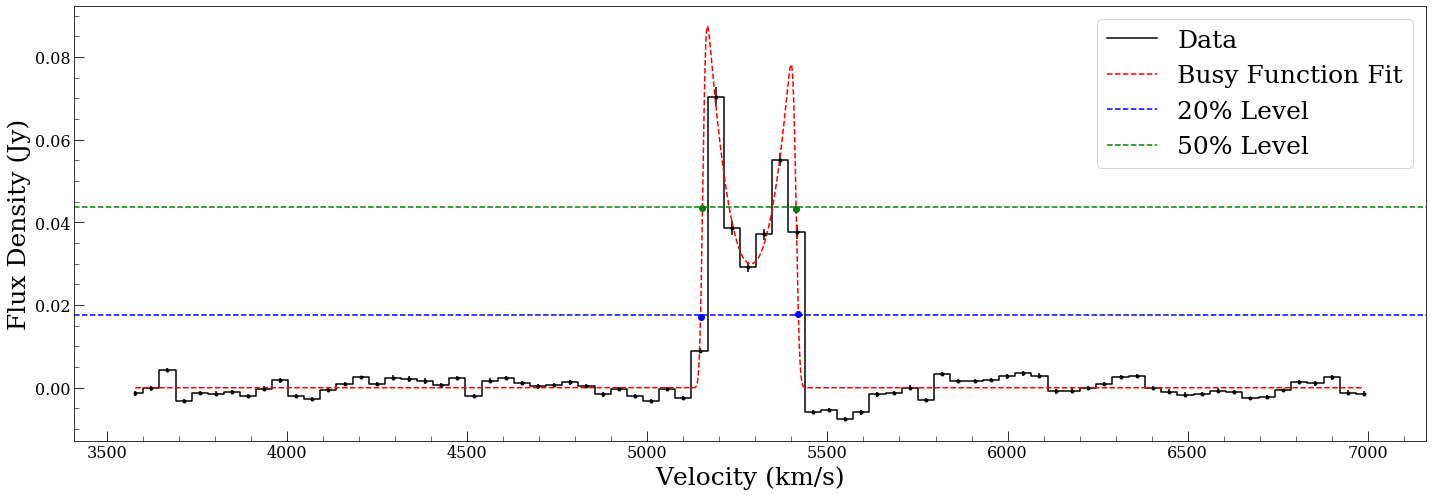

In [123]:
i = 2
# Plot the results
pl.figure(figsize=(20,7))

# The data
pl.step(vel[i].value, cont_sub[i].value, 'k', where='mid', label='Data')
pl.errorbar(vel[i].value, cont_sub[i].value, yerr=cont_sub_err[i].value, fmt='k.')

# The busy function fit
pl.plot(x_val_3, y_val_3, 'r--', label='Busy Function Fit')

# 20% level
pl.plot(vel_20_3[ind20_3[0]], flux20_3[ind20_3[0]], 'bo')
pl.plot(vel_20_3[ind20_3[1]], flux20_3[ind20_3[1]], 'bo')
pl.axhline(y=l20_3, color='b', linestyle='--', label=r'20% Level')

# 50% level
pl.plot(vel_50_3[ind50_3[0]], flux50_3[ind50_3[0]], 'go')
pl.plot(vel_50_3[ind50_3[1]], flux50_3[ind50_3[1]], 'go')
pl.axhline(y=l50_3, color='g', linestyle='--', label=r'50% Level')

pl.gca().xaxis.set_minor_locator(AutoMinorLocator())
pl.gca().yaxis.set_minor_locator(AutoMinorLocator())
pl.tick_params(which='major', direction='in', length=10)
pl.tick_params(which='minor', direction='in', length=5)
pl.xlabel('Velocity (km/s)', fontsize=25)
pl.ylabel('Flux Density (Jy)', fontsize=25)
pl.tight_layout()
pl.legend(fontsize=25)

In [124]:
i = 2

# Open text file to write to
path = '/users/wanga/mightee/analysis/busy_function/bf_pymultinest/'
f = open(path+'XMMLSS12_1380_detection3_bf.txt','w+')

for j in range(len(vel[i])):
     f.write('%f %f %f\n'%(vel[i][j].value, cont_sub[i][j].value, cont_sub_err[i][j].value))
f.close()

### 8.3.4. Detection 4

In [125]:
i = 3
# Initial guesses for detection 1
a_4, b1_4, b2_4, w_4, xe_4, xp_4, c_4, n_4 = max(cont_sub[i].value), 0.03, 0.03, 50, central_vel[i].value, central_vel[i].value, 1e-12, 2

# Store the guesses in a list
det4_guess = [a_4, b1_4, b2_4, w_4, xe_4, xp_4, c_4, n_4]

# Use scipy to perform the busy function fit
popt4, pcov4 = curve_fit(B, vel[i].value[index_a[i]-3:index_b[i]+3], cont_sub[i].value[index_a[i]-3:index_b[i]+3], 
                         p0=det4_guess, sigma=cont_sub_err[i].value[index_a[i]-3:index_b[i]+3], absolute_sigma=True, 
                         bounds=((0, 0, 0, 40, 3500, 3500, 0, 2),(np.inf, np.inf, np.inf, 70, 4500, 4500, np.inf, 8)), 
                         maxfev=10000)

popt4

array([2.20880794e-02, 7.19412884e-02, 7.20135998e-02, 5.57941040e+01,
       3.91381704e+03, 3.92810730e+03, 2.05486910e-06, 2.00000002e+00])

To see whether the fit is good, we need to perform a $\chi^2$ test:

In [126]:
i = 3
# Calculate the chi^2/dof
# f(x)
Bx = B(vel[i].value[index_a[i]-3:index_b[i]+3], popt4[0], popt4[1], popt4[2], popt4[3], popt4[4], popt4[5], popt4[6], popt4[7])

# y
y = cont_sub[i].value[index_a[i]-3:index_b[i]+3]

# sum(f(x) - y)^2
chi = np.sum(pow(Bx - y,2)/pow(cont_sub_err[i].value[index_a[i]-3:index_b[i]+3],2))

# Degrees of freedom
dof = len(vel[i][index_a[i]-3:index_b[i]+3]) - len(popt4)

print("min chi/dof", chi/dof)

min chi/dof 122.75208381630794


In [127]:
i = 3
# Calculate the values based on the parameters
x_val_4 = np.linspace(min(vel[i].value), max(vel[i].value), 10000)
y_val_4 = B(x_val_4, popt4[0], popt4[1], popt4[2], popt4[3], popt4[4], popt4[5], popt4[6], popt4[7])

In [128]:
# Calculate W50
W50fit_4 = 2*popt4[3] 
W50calc_4, l50_4, ind50_4, vel_50_4, flux50_4 = calc_w(x_val_4, y_val_4, 50, 50)

# Calculate W20
W20_4, l20_4, ind20_4, vel_20_4, flux20_4 = calc_w(x_val_4, y_val_4, 20, 50)

In [129]:
i = 3
# Calculate the SNR
meanrms4 = np.mean(flux_err[i][index_a[i]:index_b[i]+3]).value # calculate the average rms over the line for this detection 

SNR4 = (line_jykms[i].value*np.sqrt(W50calc_4/(2*dv_det[i].value)))/(meanrms4*W50calc_4)

# Calculate the error in w20
uW20_4 = 3*(W20_4 - W50calc_4)/SNR4

# Calculate the error in w50
uW50_4 = 4.7*(W20_4 - W50calc_4)/SNR4

In [130]:
i = 3
print('W20 = %.2f +/- %.2f km/s'%(W20_4, (np.sqrt(pow(uW20_4,2) +pow(dv_det[i].value/2,2)))))
print()
print('W50 from fit = %.2f +/- %.2f km/s'%(W50fit_4, (np.sqrt(pow(uW50_4,2) + pow(dv_det[i].value/2,2)))))
print('W50 from function = %.2f +/- %.2f km/s'%(W50calc_4, uW50_4))

W20 = 128.34 +/- 22.35 km/s

W50 from fit = 111.59 +/- 22.37 km/s
W50 from function = 111.82 +/- 1.07 km/s


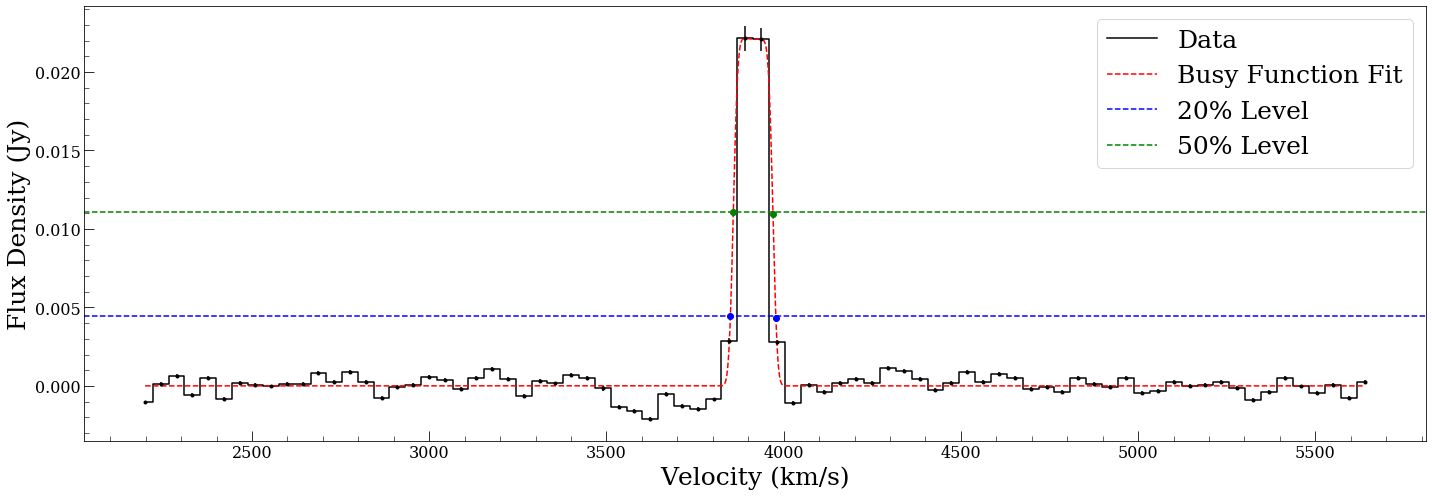

In [131]:
i = 3
# Plot the results
pl.figure(figsize=(20,7))

# The data
pl.step(vel[i].value, cont_sub[i].value, 'k', where='mid', label='Data')
pl.errorbar(vel[i].value, cont_sub[i].value, yerr=cont_sub_err[i].value, fmt='k.')

# The busy function fit
pl.plot(x_val_4, y_val_4, 'r--', label='Busy Function Fit')

# 20% level
pl.plot(vel_20_4[ind20_4[0]], flux20_4[ind20_4[0]], 'bo')
pl.plot(vel_20_4[ind20_4[1]], flux20_4[ind20_4[1]], 'bo')
pl.axhline(y=l20_4, color='b', linestyle='--', label=r'20% Level')

# 50% level
pl.plot(vel_50_4[ind50_4[0]], flux50_4[ind50_4[0]], 'go')
pl.plot(vel_50_4[ind50_4[1]], flux50_4[ind50_4[1]], 'go')
pl.axhline(y=l50_4, color='g', linestyle='--', label=r'50% Level')

pl.gca().xaxis.set_minor_locator(AutoMinorLocator())
pl.gca().yaxis.set_minor_locator(AutoMinorLocator())
pl.tick_params(which='major', direction='in', length=10)
pl.tick_params(which='minor', direction='in', length=5)
pl.xlabel('Velocity (km/s)', fontsize=25)
pl.ylabel('Flux Density (Jy)', fontsize=25)
pl.tight_layout()
pl.legend(fontsize=25)

#### 6.3.2.5. Detection 5

In [132]:
i = 4
# Initial guesses for detection 5
a_5, b1_5, b2_5, w_5, xe_5, xp_5, c_5, n_5 = max(cont_sub[i].value), 0.1, 0.08, 85, central_vel[i].value, central_vel[i].value, 0.00007, 2

# Store the guesses in a list
det5_guess = [a_5, b1_5, b2_5, w_5, xe_5, xp_5, c_5, n_5]

# Use scipy to perform the busy function fit
popt5, pcov5 = curve_fit(B, vel[i].value[index_a[i]-3:index_b[i]+3], cont_sub[i].value[index_a[i]-3:index_b[i]+3], 
                         p0=det5_guess, sigma=cont_sub_err[i].value[index_a[i]-3:index_b[i]+3], absolute_sigma=True, 
                         bounds=((0, 0, 0, 40, 2000, 2000, 0, 2),(np.inf, np.inf, np.inf, 110, 2500, 2500, np.inf, 8)), 
                         maxfev=10000)

popt5

array([4.67154841e-02, 8.67160232e-01, 3.83986839e-01, 8.10852704e+01,
       2.29965082e+03, 2.34153913e+03, 1.17777905e-04, 2.00111101e+00])

To see whether the fit is good, we need to perform a $\chi^2$ test:

In [133]:
i = 4
# Calculate the chi^2/dof
# f(x)
Bx = B(vel[i].value[index_a[i]-3:index_b[i]+3], popt5[0], popt5[1], popt5[2], popt5[3], popt5[4], popt5[5], popt5[6], popt5[7])

# y
y = cont_sub[i].value[index_a[i]-3:index_b[i]+3]

# sum(f(x) - y)^2
chi = np.sum(pow(Bx - y,2)/pow(cont_sub_err[i].value[index_a[i]-3:index_b[i]+3],2))

# Degrees of freedom
dof = len(vel[i][index_a[i]-3:index_b[i]+3]) - len(popt2)

print("min chi/dof", chi/dof)

min chi/dof 50.330000221094316


In [134]:
i = 4
# Calculate the values based on the parameters
x_val_5 = np.linspace(min(vel[i].value), max(vel[i].value), 10000)
y_val_5 = B(x_val_5, popt5[0], popt5[1], popt5[2], popt5[3], popt5[4], popt5[5], popt5[6], popt5[7])

In [135]:
# Calculate W50
W50fit_5 = 2*popt5[3] 
W50calc_5, l50_5, ind50_5, vel_50_5, flux50_5 = calc_w(x_val_5, y_val_5, 50, 18)

# Calculate W20
W20_5, l20_5, ind20_5, vel_20_5, flux20_5 = calc_w(x_val_5, y_val_5, 20, 400)

In [136]:
i = 4
# Calculate the SNR
meanrms5 = np.mean(flux_err[i][index_a[i]-3:index_b[i]+3]).value # calculate the average rms over the line for this detection 

SNR5 = (line_jykms[i].value*np.sqrt(W50calc_5/(2*dv_det[i].value)))/(meanrms5*W50calc_5)

# Calculate the error in w20
uW20_5 = 3*(W20_5 - W50calc_5)/SNR5

# Calculate the error in w50
uW50_5 = 4.7*(W20_5 - W50calc_5)/SNR5

In [137]:
i = 4
print('W20 = %.2f +/- %.2f km/s'%(W20_5, (np.sqrt(pow(uW20_5,2) +pow(dv_det[i].value/2,2)))))
print()
print('W50 from fit = %.2f +/- %.2f km/s'%(W50fit_5, (np.sqrt(pow(uW50_5,2) + pow(dv_det[i].value/2,2)))))
print('W50 from function = %.2f +/- %.2f km/s'%(W50calc_5, uW50_5))

W20 = 163.27 +/- 23.00 km/s

W50 from fit = 162.17 +/- 24.07 km/s
W50 from function = 6.50 +/- 9.26 km/s


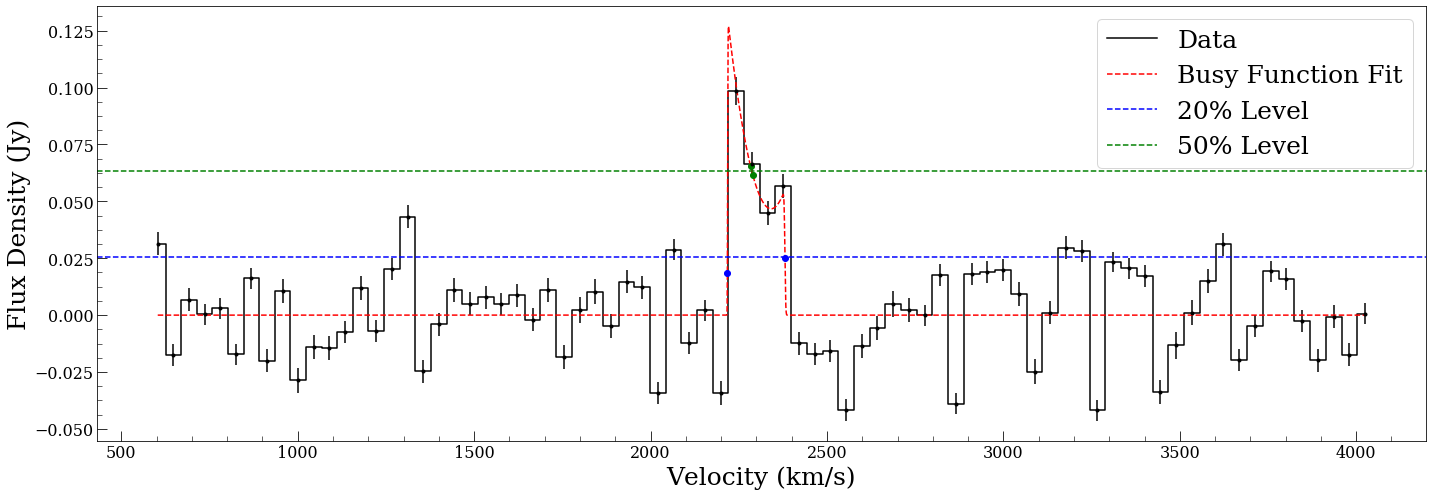

In [138]:
i = 4
# Plot the results
pl.figure(figsize=(20,7))

# The data
pl.step(vel[i].value, cont_sub[i].value, 'k', where='mid', label='Data')
pl.errorbar(vel[i].value, cont_sub[i].value, yerr=cont_sub_err[i].value, fmt='k.')

# The busy function fit
pl.plot(x_val_5, y_val_5, 'r--', label='Busy Function Fit')

# 20% level
pl.plot(vel_20_5[ind20_5[0]], flux20_5[ind20_5[0]], 'bo')
pl.plot(vel_20_5[ind20_5[1]], flux20_5[ind20_5[1]], 'bo')
pl.axhline(y=l20_5, color='b', linestyle='--', label=r'20% Level')

# 50% level
pl.plot(vel_50_5[ind50_5[0]], flux50_5[ind50_5[0]], 'go')
pl.plot(vel_50_5[ind50_5[1]], flux50_5[ind50_5[1]], 'go')
pl.axhline(y=l50_5, color='g', linestyle='--', label=r'50% Level')

pl.gca().xaxis.set_minor_locator(AutoMinorLocator())
pl.gca().yaxis.set_minor_locator(AutoMinorLocator())
pl.tick_params(which='major', direction='in', length=10)
pl.tick_params(which='minor', direction='in', length=5)
pl.xlabel('Velocity (km/s)', fontsize=25)
pl.ylabel('Flux Density (Jy)', fontsize=25)
pl.tight_layout()
pl.legend(fontsize=25)